# Setup

In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tqdm import tqdm_notebook

mpl.rcParams['figure.figsize'] = (20, 7)
mpl.rcParams['axes.grid'] = False

# Hotel Dataset

In [2]:
df = pd.read_pickle('../dataset/preprocessed/284_imputed.pkl')

In [3]:
def fill(df,col):
    df = df.pivot(index='DOA',columns='LeadTime',values=col)
    df = df.bfill(axis=1).ffill(axis=1)
    df.columns = df.columns[::-1]
    return df.stack()

In [4]:
ROH   = fill(df,'ROH')
Price = fill(df,'Price')

In [5]:
_DOA = []
_ROH = []
_Price = []
_LeadTime = []
LeadTime = np.arange(start=89, stop=-1, step=-1)
target_doa = df['DOA'].dt.strftime('%Y-%m-%d').unique()
for DOA in tqdm_notebook(target_doa):
    _DOA = np.append(_DOA,np.full((90),DOA))
    _LeadTime = np.append(_LeadTime,LeadTime)
    _Price = np.append(_Price,Price.loc[DOA].values)
    _ROH = np.append(_ROH,ROH.loc[DOA].values)

df = pd.DataFrame({
    "DOA":_DOA,
    "LeadTime":_LeadTime,
    "Price":_Price,
    "ROH":_ROH,
})

In [6]:
df.head(10)

DOA  LeadTime   Price    ROH
0  2018-01-01      89.0   40.47  209.0
1  2018-01-01      88.0   40.47  206.0
2  2018-01-01      87.0  136.10  206.0
3  2018-01-01      86.0  136.10  198.0
4  2018-01-01      85.0   40.47  204.0
5  2018-01-01      84.0   44.92  198.0
6  2018-01-01      83.0   62.71  196.0
7  2018-01-01      82.0   62.71  199.0
8  2018-01-01      81.0   62.71  197.0
9  2018-01-01      80.0   62.71  189.0

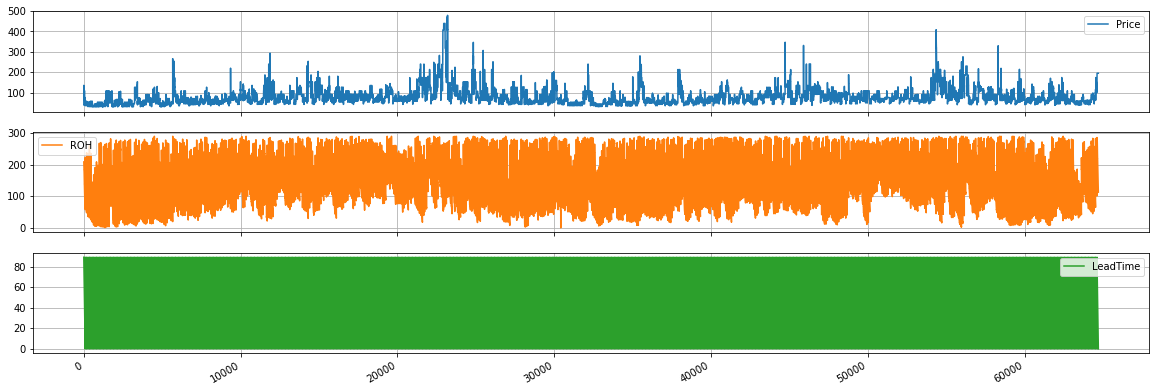

In [7]:
plot_cols = ['Price', 'ROH', 'LeadTime']
plot_features = df[plot_cols]
_ = plot_features.plot(subplots=True,grid=True)

# plot_features = df[plot_cols][:160]
# plot_features.index = df['DOA'][:160]
# _ = plot_features.plot(subplots=True)

In [8]:
df.describe(include='all').transpose()

count unique         top freq     mean      std    min    25%  \
DOA       64710    719  2018-05-14   90      NaN      NaN    NaN    NaN   
LeadTime  64710    NaN         NaN  NaN     44.5  25.9794      0     22   
Price     64710    NaN         NaN  NaN  78.2066  39.7503  30.24  53.82   
ROH       64710    NaN         NaN  NaN  126.704  71.3347      0     69   

            50%    75%    max  
DOA         NaN    NaN    NaN  
LeadTime   44.5     67     89  
Price     67.16  91.62  479.3  
ROH         116    177    290

## Feature Engineering 
The `Date Time` column is very useful, but not in this string form. Start by converting it to seconds:

0        2018-01-01
1        2018-01-01
2        2018-01-01
3        2018-01-01
4        2018-01-01
            ...    
64705    2019-12-31
64706    2019-12-31
64707    2019-12-31
64708    2019-12-31
64709    2019-12-31
Name: DOA, Length: 64710, dtype: object

In [13]:
# This is a hack to combine both datetime columns
from datetime import timedelta 
# df['DOA'] = df['DOA']+df['LeadTime'].apply(lambda x: timedelta(minutes=(1440-((x+1)*16)))) 
df['DOA'] = pd.to_datetime(df['DOA'],format='%Y-%m-%d')
timestamp_s = df['DOA'].map(datetime.datetime.timestamp)

Similar to the wind direction the time in seconds is not a useful model input. Being weather data it has clear daily and yearly periodicity. There are many ways you could deal with periodicity.

A simple approach to convert it to a usable signal is to use `sin` and `cos` to convert the time to clear "Time of day" and "Time of year" signals:

In [14]:
day = 24*60*60
week = 7*day
month = 30.5*day
year = (365.2425)*day

# df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
# df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Week sin'] = np.sin(timestamp_s * (2 * np.pi / week))
df['Week cos'] = np.cos(timestamp_s * (2 * np.pi / week))
df['Month sin'] = np.sin(timestamp_s * (2 * np.pi / month))
df['Month cos'] = np.cos(timestamp_s * (2 * np.pi / month))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

In [15]:
df = df.set_index('DOA')

df.head(10)

LeadTime   Price    ROH  Week sin  Week cos  Month sin  Month cos  \
DOA                                                                             
2018-01-01      89.0   40.47  209.0 -0.399892 -0.916562  -0.909308   0.416125   
2018-01-01      88.0   40.47  206.0 -0.399892 -0.916562  -0.909308   0.416125   
2018-01-01      87.0  136.10  206.0 -0.399892 -0.916562  -0.909308   0.416125   
2018-01-01      86.0  136.10  198.0 -0.399892 -0.916562  -0.909308   0.416125   
2018-01-01      85.0   40.47  204.0 -0.399892 -0.916562  -0.909308   0.416125   
2018-01-01      84.0   44.92  198.0 -0.399892 -0.916562  -0.909308   0.416125   
2018-01-01      83.0   62.71  196.0 -0.399892 -0.916562  -0.909308   0.416125   
2018-01-01      82.0   62.71  199.0 -0.399892 -0.916562  -0.909308   0.416125   
2018-01-01      81.0   62.71  197.0 -0.399892 -0.916562  -0.909308   0.416125   
2018-01-01      80.0   62.71  189.0 -0.399892 -0.916562  -0.909308   0.416125   

            Year sin  Year cos  
DOA                             
2018-01-01  0.005476  0.999985  
2018-01-01  0.005476  0.999985  
2018-01-01  0.005476  0.999985  
2018-01-01  0.005476  0.999985  
2018-01-01  0.005476  0.999985  
2018-01-01  0.005476  0.999985  
2018-01-01  0.005476  0.999985  
2018-01-01  0.005476  0.999985  
2018-01-01  0.005476  0.999985  
2018-01-01  0.005476  0.999985

Text(0.5, 1.0, 'Time of day signal')

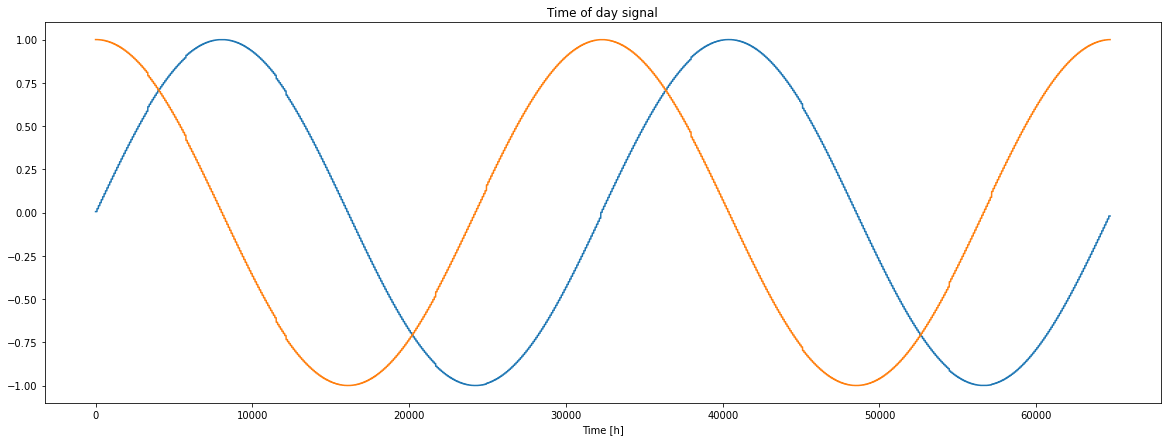

In [16]:
plt.plot(np.array(df['Year sin']))
plt.plot(np.array(df['Year cos']))
plt.xlabel('Time [h]')
plt.title('Time of day signal')

This gives the model access to the most important frequency features. In this case you knew ahead of time which frequencies were important. 

If you didn't know, you can determine which frequencies are important using an `fft`. To check our assumptions, here is the `tf.signal.rfft` of the temperature over time. Note the obvious peaks at frequencies near `1/year` and `1/day`:

In [12]:
# fft = tf.signal.rfft(df['ROH'])
# f_per_dataset = np.arange(0, len(fft))

# n_samples_h = len(df['ROH'])
# hours_per_year = 24*365.2524
# years_per_dataset = n_samples_h/(hours_per_year)

# f_per_year = f_per_dataset/years_per_dataset
# plt.step(f_per_year, np.abs(fft))
# plt.xscale('log')
# plt.ylim(0, 1000000)
# plt.xlim([0.1, max(plt.xlim())])
# plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
# _ = plt.xlabel('Frequency (log scale)')

## Split the data
We'll use a `(70%, 20%, 10%)` split for the training, validation, and test sets. Note the data is **not** being randomly shuffled before splitting. This is for two reasons.

1. It ensures that chopping the data into windows of consecutive samples is still possible.
2. It ensures that the validation/test results are more realistic, being evaluated on data collected after the model was trained.

In [13]:
# df['occ'] = df['ROH']/df['TotalCapacity']

In [17]:
# date_time = df.pop('DOA')
# lead_time = df.pop('LeadTime')
# ROH = df.pop('ROH')
df['DOW'] = df.index.dayofweek
df['Mon'] = df.index.month

In [18]:
df

LeadTime   Price    ROH  Week sin  Week cos  Month sin  Month cos  \
DOA                                                                             
2018-01-01      89.0   40.47  209.0 -0.399892 -0.916562  -0.909308   0.416125   
2018-01-01      88.0   40.47  206.0 -0.399892 -0.916562  -0.909308   0.416125   
2018-01-01      87.0  136.10  206.0 -0.399892 -0.916562  -0.909308   0.416125   
2018-01-01      86.0  136.10  198.0 -0.399892 -0.916562  -0.909308   0.416125   
2018-01-01      85.0   40.47  204.0 -0.399892 -0.916562  -0.909308   0.416125   
...              ...     ...    ...       ...       ...        ...        ...   
2019-12-31       4.0  195.33  126.0 -0.965926 -0.258819  -0.982223  -0.187719   
2019-12-31       3.0  195.33  122.0 -0.965926 -0.258819  -0.982223  -0.187719   
2019-12-31       2.0  195.33  118.0 -0.965926 -0.258819  -0.982223  -0.187719   
2019-12-31       1.0  195.33  116.0 -0.965926 -0.258819  -0.982223  -0.187719   
2019-12-31       0.0  195.33  113.0 -0.965926 -0.258819  -0.982223  -0.187719   

            Year sin  Year cos  DOW  Mon  
DOA                                       
2018-01-01  0.005476  0.999985    0    1  
2018-01-01  0.005476  0.999985    0    1  
2018-01-01  0.005476  0.999985    0    1  
2018-01-01  0.005476  0.999985    0    1  
2018-01-01  0.005476  0.999985    0    1  
...              ...       ...  ...  ...  
2019-12-31 -0.020069  0.999799    1   12  
2019-12-31 -0.020069  0.999799    1   12  
2019-12-31 -0.020069  0.999799    1   12  
2019-12-31 -0.020069  0.999799    1   12  
2019-12-31 -0.020069  0.999799    1   12  

[64710 rows x 11 columns]

In [19]:
df.head()
# df = df[['LeadTime','Price','DOW','Mon','ROH']]

LeadTime   Price    ROH  Week sin  Week cos  Month sin  Month cos  \
DOA                                                                             
2018-01-01      89.0   40.47  209.0 -0.399892 -0.916562  -0.909308   0.416125   
2018-01-01      88.0   40.47  206.0 -0.399892 -0.916562  -0.909308   0.416125   
2018-01-01      87.0  136.10  206.0 -0.399892 -0.916562  -0.909308   0.416125   
2018-01-01      86.0  136.10  198.0 -0.399892 -0.916562  -0.909308   0.416125   
2018-01-01      85.0   40.47  204.0 -0.399892 -0.916562  -0.909308   0.416125   

            Year sin  Year cos  DOW  Mon  
DOA                                       
2018-01-01  0.005476  0.999985    0    1  
2018-01-01  0.005476  0.999985    0    1  
2018-01-01  0.005476  0.999985    0    1  
2018-01-01  0.005476  0.999985    0    1  
2018-01-01  0.005476  0.999985    0    1

In [20]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

## Normalizae The Data
It is important to scale features before training a neural network. Normalization is a common way of doing this scaling. Subtract the mean and divide by the standard deviation of each feature.

The mean and standard deviation should only be computed using the training data so that the models have no access to the values in the validation and test sets.

It's also arguable that the model shouldn't have access to future values in the training set when training, and that this normalization should be done using moving averages. That's not the focus of this tutorial, and the validation and test sets ensure that you get (somewhat) honest metrics. So in the interest of simplicity this tutorial uses a simple average.

In [21]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

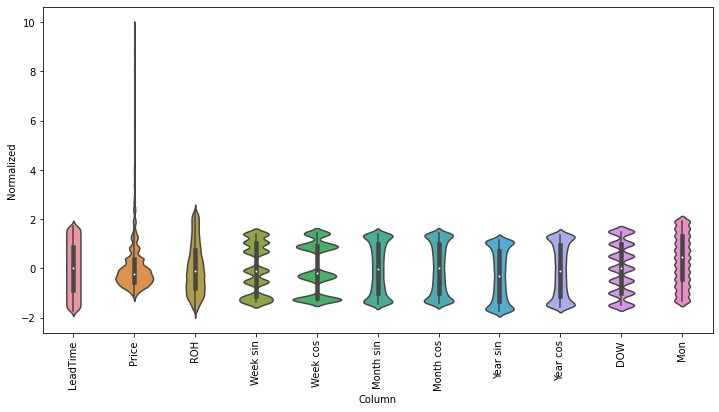

In [22]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

## Data Windowing
The models in this tutorial will make a set of predictions based on a window of consecutive samples from the data. 

The main features of the input windows are:

* The width (number of time steps) of the input and label windows
* The time offset between them.
* Which features are used as inputs, labels, or both. 

This tutorial builds a variety of models (including Linear, DNN, CNN and RNN models), and uses them for both:

* *Single-output*, and *multi-output* predictions.
* *Single-time-step* and *multi-time-step* predictions.

This section focuses on implementing the data windowing so that it can be reused for all of those models.

Depending on the task and type of model you may want to generate a variety of data windows. Here are some examples:

1. For example, to make a single prediction 24h into the future, given 24h of history you might define a window like this:

  ![One prediction 24h into the future.](images/raw_window_24h.png)

2. A model that makes a prediction 1h into the future, given 6h of history would need a window like this:

  ![One prediction 1h into the future.](images/raw_window_1h.png)

### 1. Indexes and offsets

Start by creating the `WindowGenerator` class. The `__init__` method includes all the necessary logic for the input and label indices.

It also takes the train, eval, and test dataframes as input. These will be converted to `tf.data.Dataset`s of windows later.

In [23]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

Here is code to create the 2 windows shown in the diagrams at the start of this section:

In [24]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,label_columns=['ROH'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['ROH']

In [22]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,label_columns=['ROH'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['ROH']

In [23]:
w3 = WindowGenerator(input_width=6, label_width=1, shift=1,label_columns=['ROH'])
w3

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['ROH']

### 2. Split
Given a list consecutive inputs, the `split_window` method will convert them to a window of inputs and a window of labels.

The example `w2`, above, will be split like this:

This diagram doesn't show the `features` axis of the data, but this `split_window` function also handles the `label_columns` so it can be used for both the single output and multi-output examples.

In [25]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [25]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])


example_inputs, example_labels = w3.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 11)
Inputs shape: (3, 6, 11)
labels shape: (3, 1, 1)


### 3. Plot

Here is a plot method that allows a simple visualization of the split window:

In [26]:
w2.example = example_inputs, example_labels

In [26]:
def plot(self, model=None, plot_col='ROH', max_subplots=20):
  inputs, labels = self.example
  plt.figure(figsize=(30, 40))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(20, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [d]')

WindowGenerator.plot = plot
w2.plot()

NameError: name 'w2' is not defined

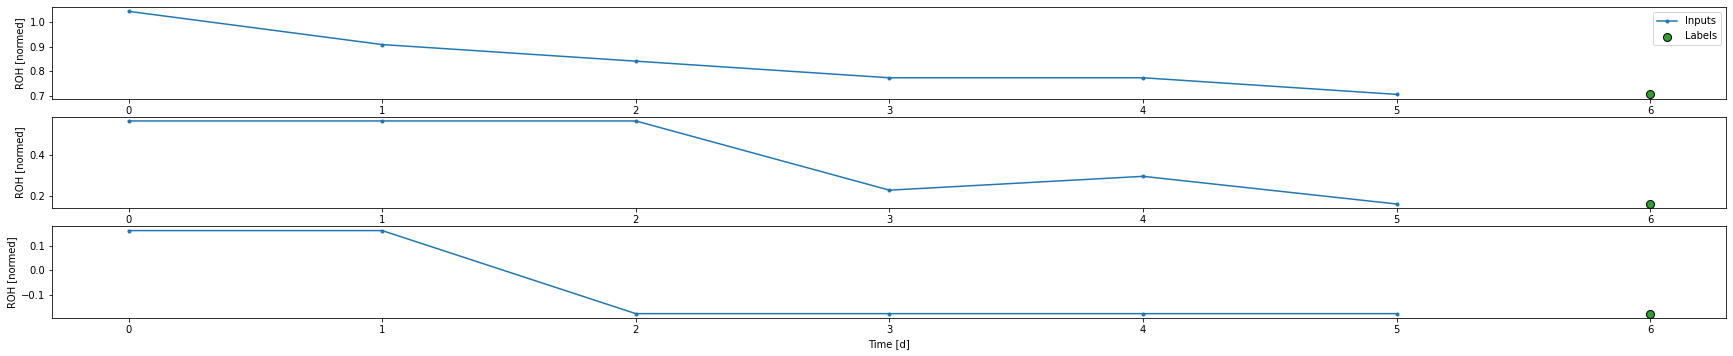

In [28]:
w2.plot()

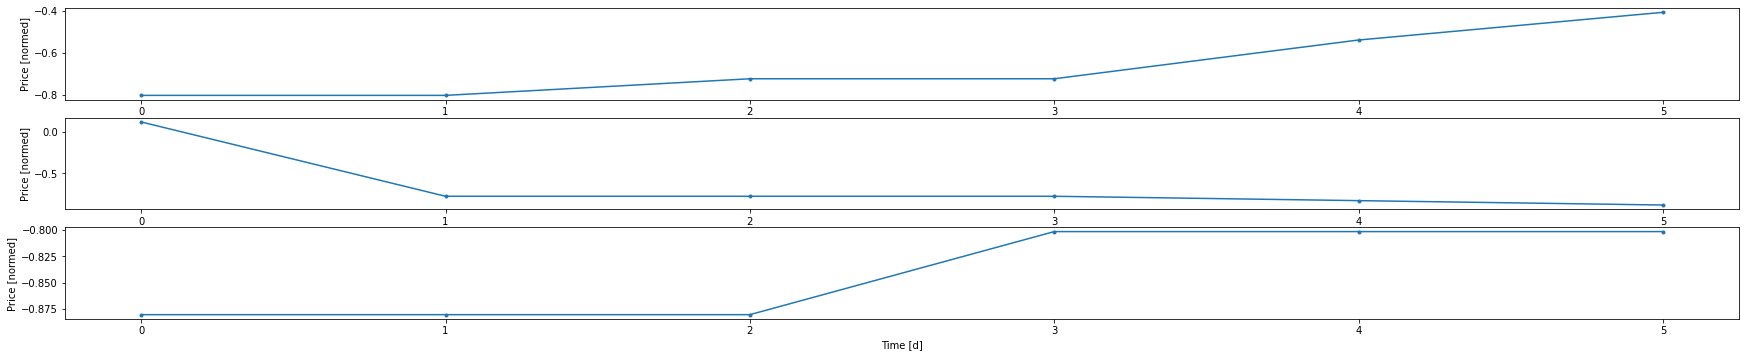

In [29]:
w2.plot(plot_col='Price')

## 4. Create `tf.data.Dataset`s
Finally this `make_dataset` method will take a time series `DataFrame` and convert it to a `tf.data.Dataset` of `(input_window, label_window)` pairs using the `preprocessing.timeseries_dataset_from_array` function.

In [27]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=90,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

The `WindowGenerator` object holds training, validation and test data. Add properties for accessing them as `tf.data.Datasets` using the above `make_dataset` method. Also add a standard example batch for easy access and plotting:

In [28]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

Now the `WindowGenerator` object gives you access to the `tf.data.Dataset` objects, so you can easily iterate over the data.

The `Dataset.element_spec` property tells you the structure, `dtypes` and shapes of the dataset elements.

In [32]:
# Each element is an (inputs, label) pair
w2.train.element_spec

(TensorSpec(shape=(None, 6, 11), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

Iterating over a `Dataset` yields concrete batches:

In [33]:
for example_inputs, example_labels in w3.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (90, 6, 11)
Labels shape (batch, time, features): (90, 1, 1)


## Single step models

The simplest model you can build on this sort of data is one that predicts a single feature's value, 1 timestep (1h) in the future based only on the current conditions.

So start by building models to predict the `Reservation` value 1h into the future.

Configure a `WindowGenerator` object to produce these single-step `(input, label)` pairs:

In [34]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['ROH'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['ROH']

In [35]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (90, 1, 11)
Labels shape (batch, time, features): (90, 1, 1)


### Baseline

Before building a trainable model it would be good to have a performance baseline as a point for comparison with the later more complicated models.

This first task is to predict temperature 1h in the future given the current value of all features. The current values include the current temperature. 

So start with a model that just returns the current temperature as the prediction, predicting "No change". This is a reasonable baseline since temperature changes slowly. Of course, this baseline will work less well if you make a prediction further in the future.

In [36]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

Instantiate and evaluate this model:

In [37]:
baseline = Baseline(label_index=column_indices['ROH'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

133/133 [==============================] - 0s 3ms/step - loss: 0.0671 - mean_absolute_error: 0.0551


That printed some performance metrics, but those don't give you a feeling for how well the model is doing.

The `WindowGenerator` has a plot method, but the plots won't be very interesting with only a single sample. So, create a wider `WindowGenerator` that generates windows 24h of consecutive inputs and labels at a time. 

The `wide_window` doesn't change the way the model operates. The model still makes predictions 1h into the future based on a single input time step. Here the `time` axis acts like the `batch` axis: Each prediction is made independently with no interaction between time steps.

In [35]:
wide_window = WindowGenerator(input_width=90, label_width=90, shift=1,label_columns=['ROH'])

wide_window

Total window size: 91
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90]
Label column name(s): ['ROH']

This expanded window can be passed directly to the same `baseline` model without any code changes. This is possible because the inputs and labels have the same number of timesteps, and the baseline just forwards the input to the output:

In [36]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (90, 90, 11)
Output shape: (90, 90, 1)


Plotting the baseline model's predictions you can see that it is simply the labels, shifted right by 1h.

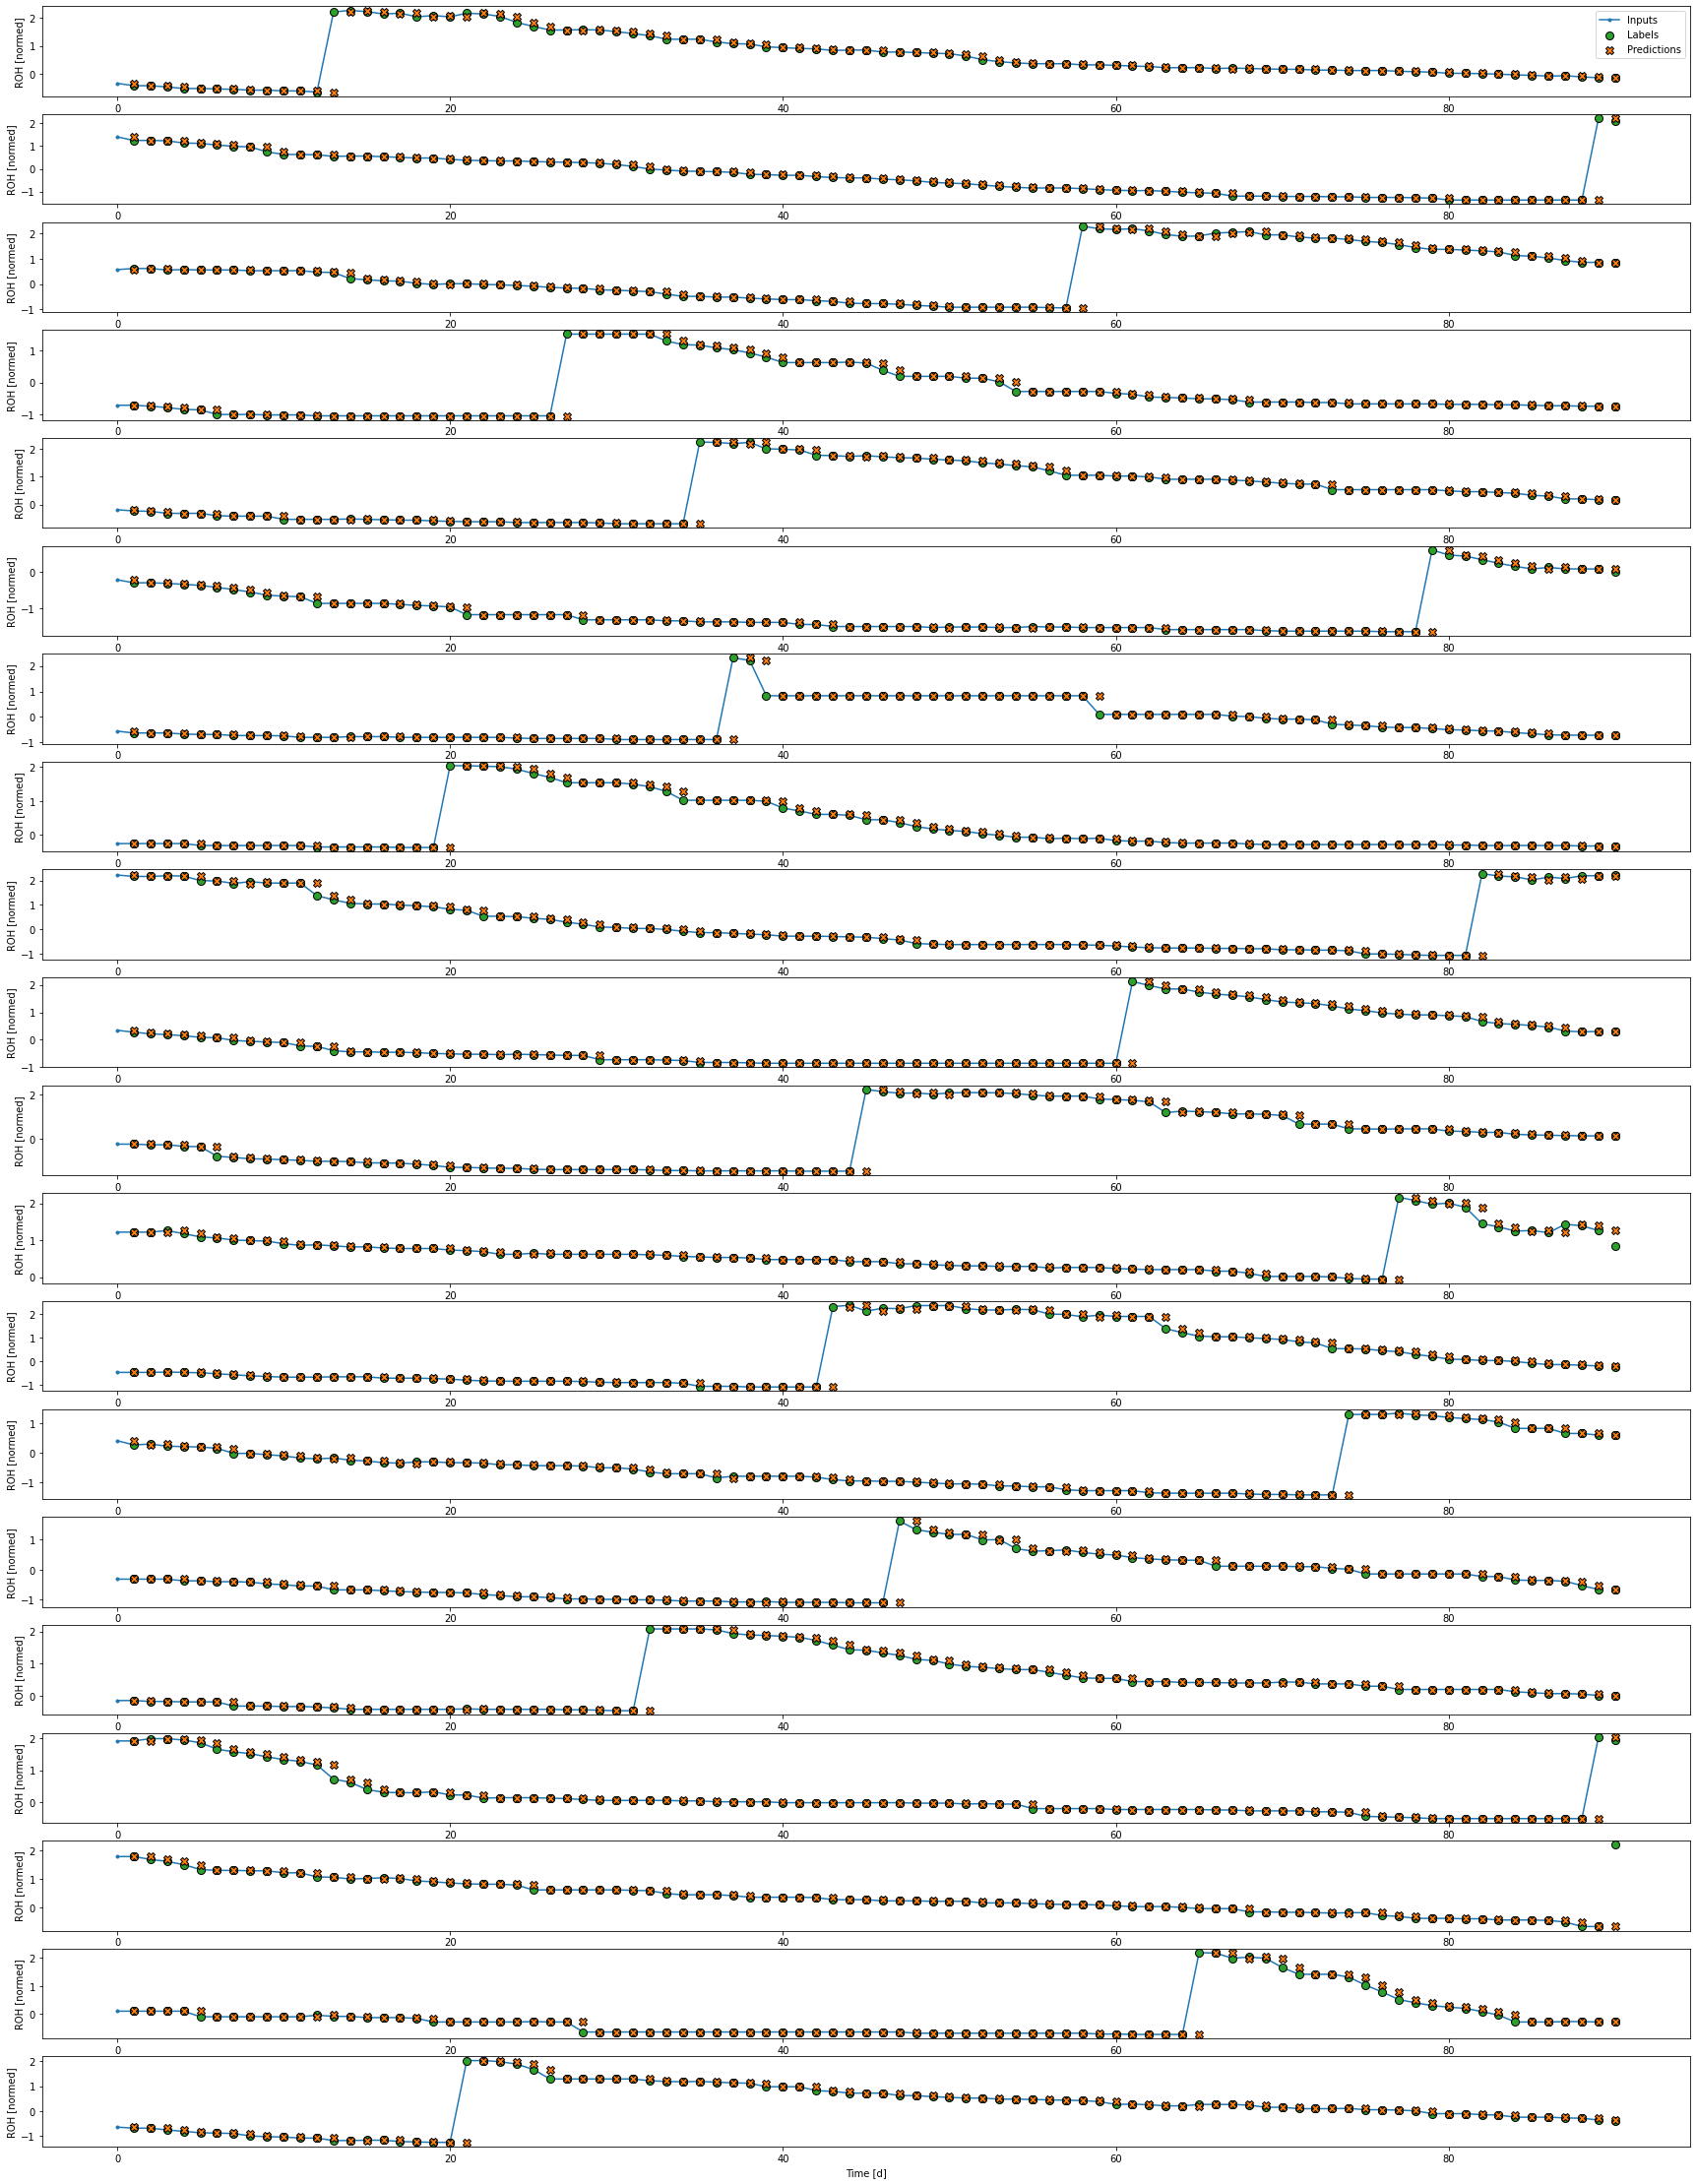

In [37]:
wide_window.plot(baseline)

### Linear model

The simplest **trainable** model you can apply to this task is to insert linear transformation between the input and output. In this case the output from a time step only depends on that step:

A `layers.Dense` with no `activation` set is a linear model. The layer only transforms the last axis of the data from `(batch, time, inputs)` to `(batch, time, units)`, it is applied independently to every item across the `batch` and `time` axes.

In [38]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['ROH'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['ROH']

In [39]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [40]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (90, 1, 11)
Output shape: (90, 1, 1)


In [31]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),optimizer=tf.optimizers.Adam(), metrics=[tf.metrics.MeanAbsoluteError()])
  
  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [44]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

NameError: name 'linear' is not defined

In [48]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (90, 24, 11)
Output shape: (90, 24, 1)


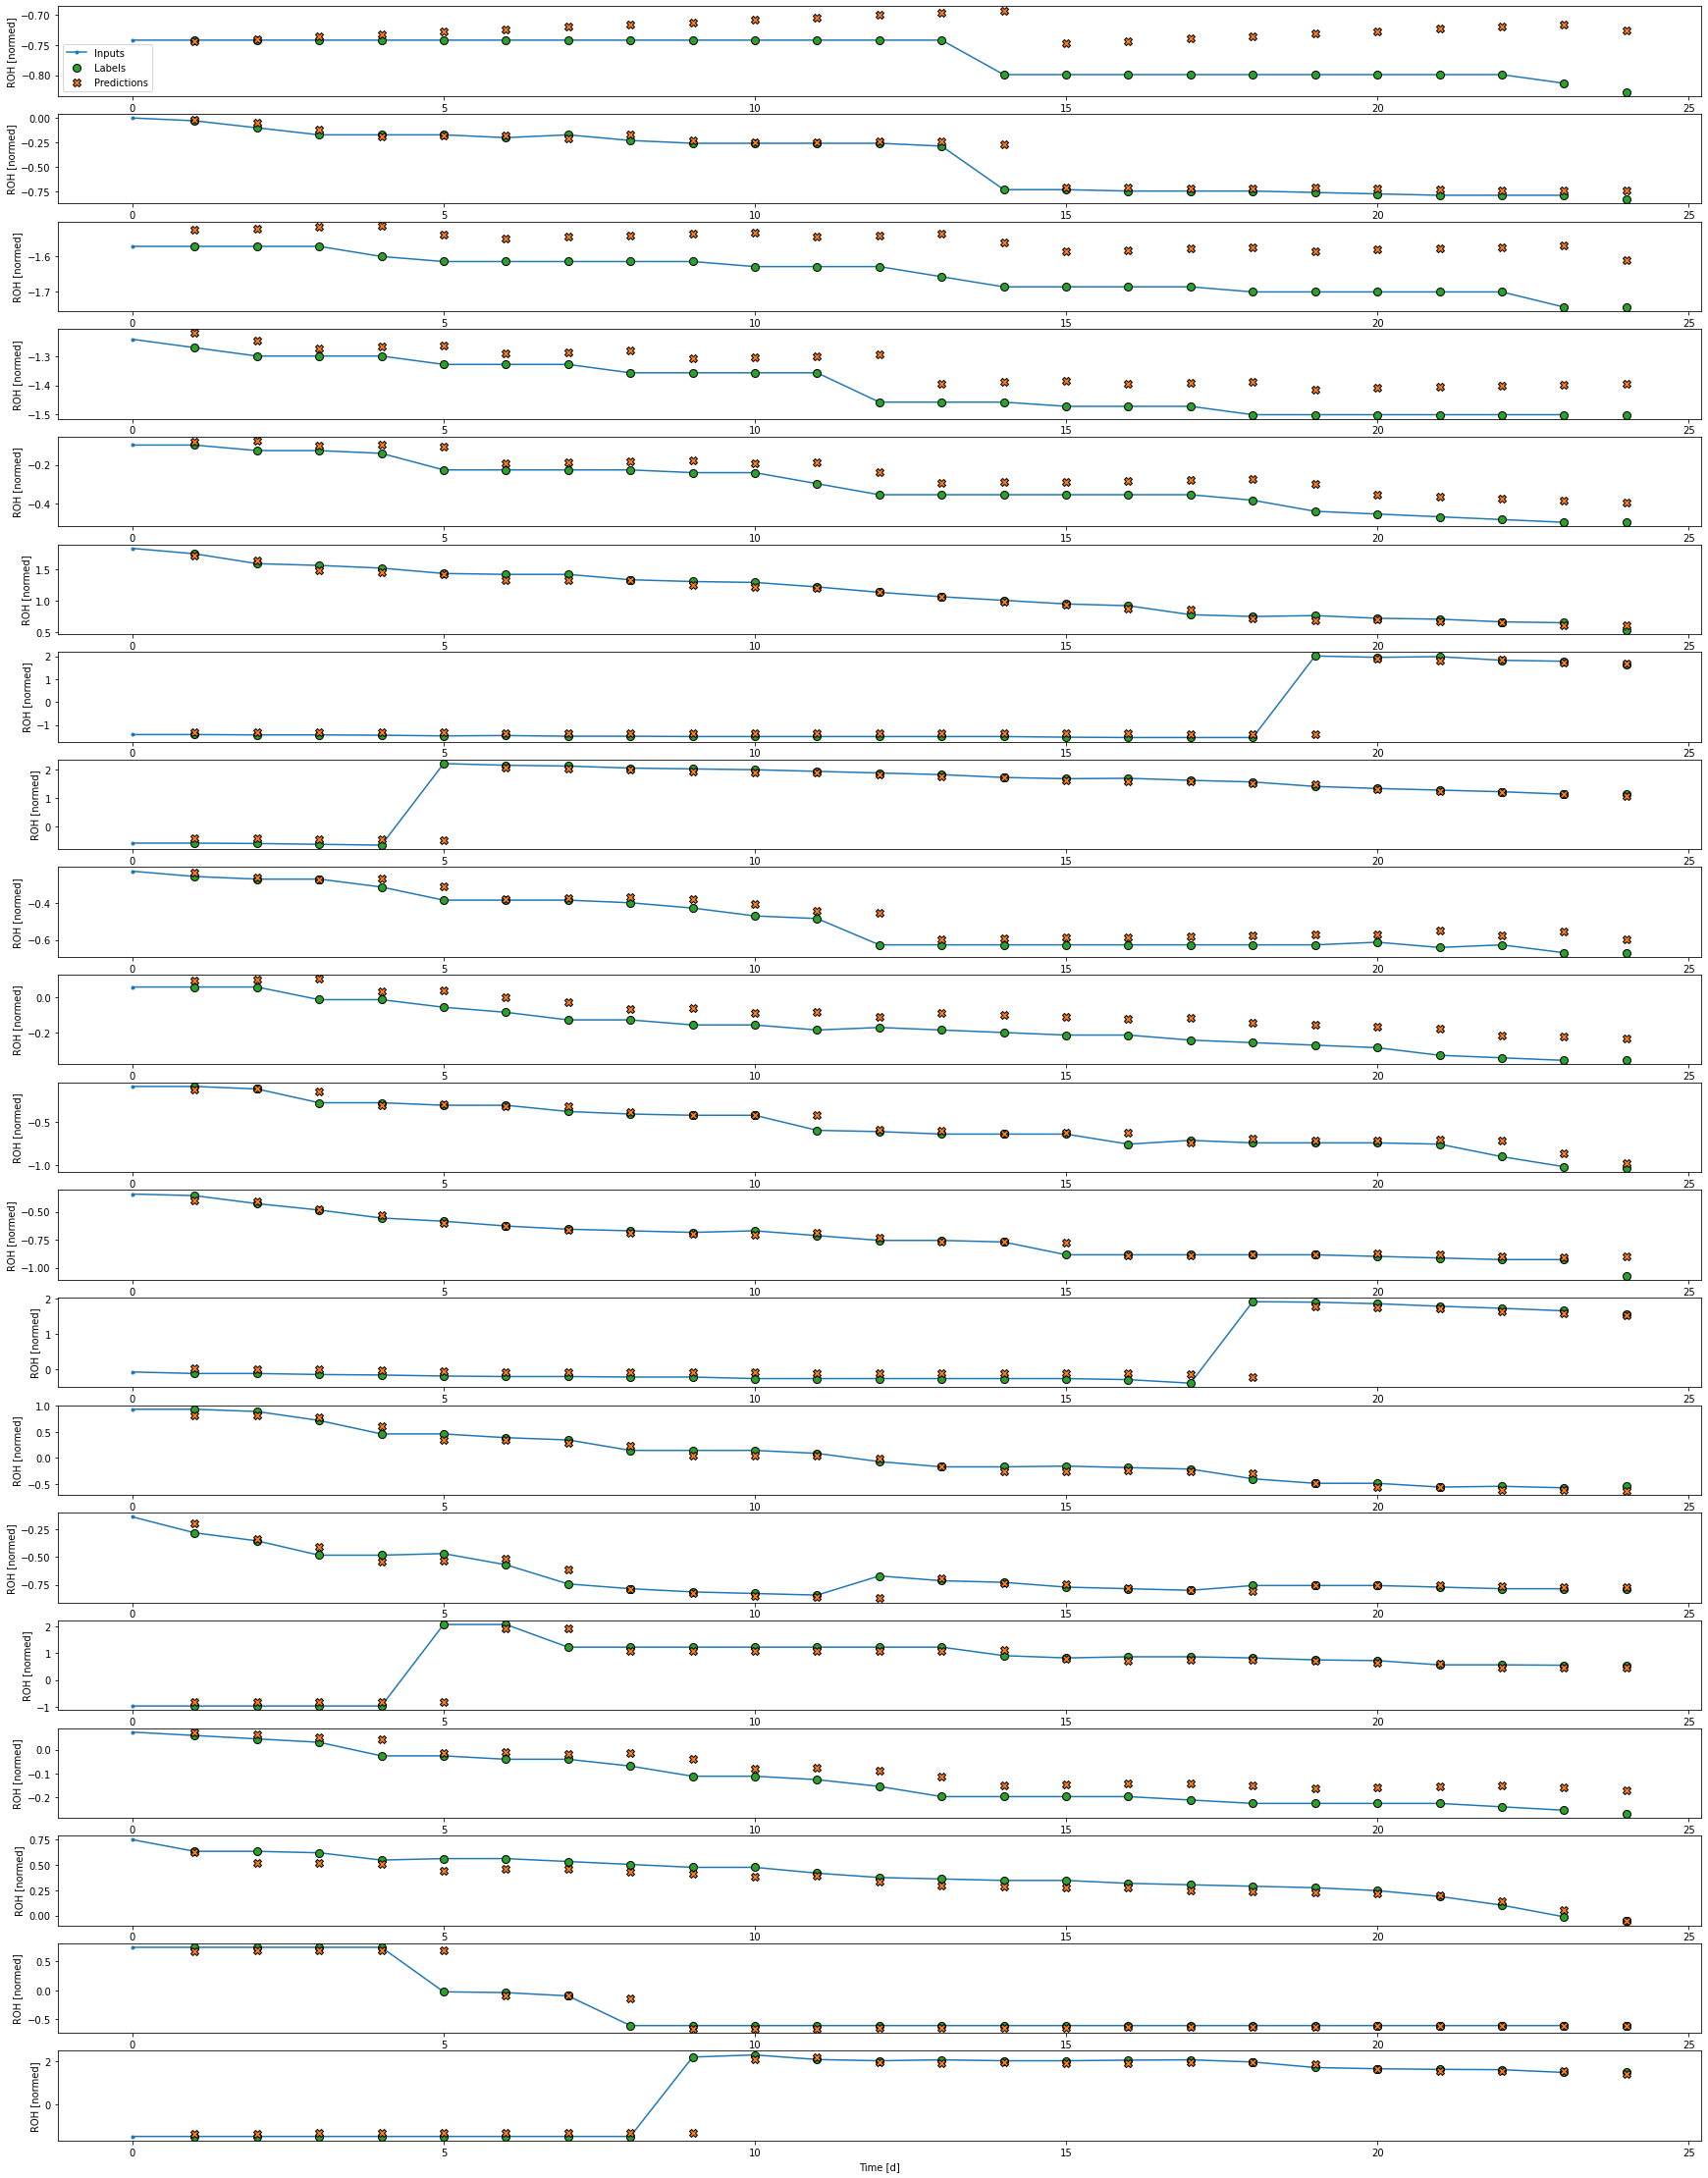

In [49]:
wide_window.plot(linear)

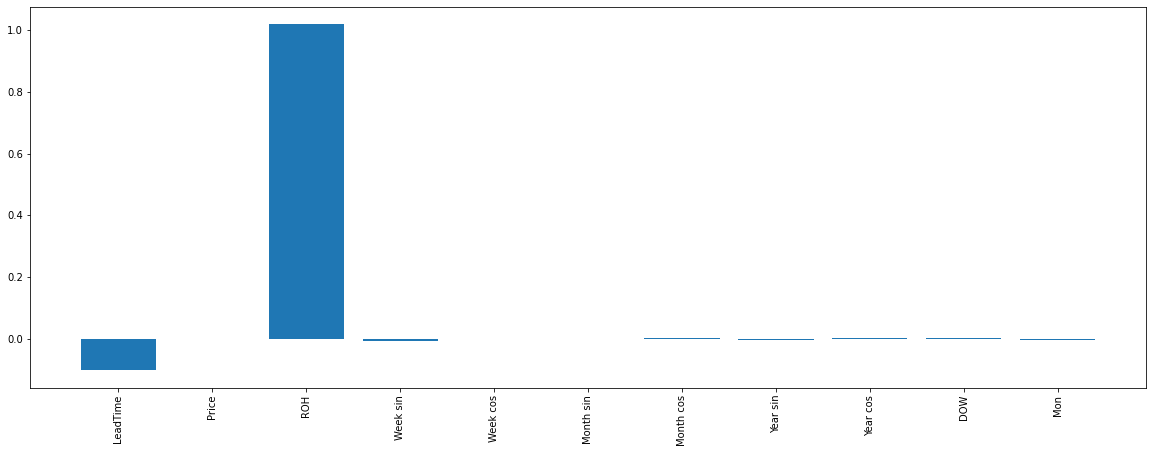

In [50]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

## Dense

In [50]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
504/504 [==============================] - 3s 5ms/step - loss: 0.1334 - mean_absolute_error: 0.1664 - val_loss: 0.1053 - val_mean_absolute_error: 0.1510
Epoch 2/20
504/504 [==============================] - 2s 4ms/step - loss: 0.1026 - mean_absolute_error: 0.1244 - val_loss: 0.1008 - val_mean_absolute_error: 0.1470
Epoch 3/20
504/504 [==============================] - 2s 4ms/step - loss: 0.0981 - mean_absolute_error: 0.1189 - val_loss: 0.0945 - val_mean_absolute_error: 0.1354
Epoch 4/20
504/504 [==============================] - 3s 5ms/step - loss: 0.0942 - mean_absolute_error: 0.1162 - val_loss: 0.0884 - val_mean_absolute_error: 0.1172
Epoch 5/20
504/504 [==============================] - 3s 5ms/step - loss: 0.0909 - mean_absolute_error: 0.1117 - val_loss: 0.0880 - val_mean_absolute_error: 0.1257
Epoch 6/20
504/504 [==============================] - 3s 5ms/step - loss: 0.0871 - mean_absolute_error: 0.1076 - val_loss: 0.0838 - val_mean_absolute_error: 0.1203
Epoch 7/20
504/5

In [58]:
CONV_WIDTH = 29
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['ROH'])

conv_window

Total window size: 30
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28]
Label indices: [29]
Label column name(s): ['ROH']

Text(0.5, 1.0, 'Given 3h as input, predict 1h into the future.')

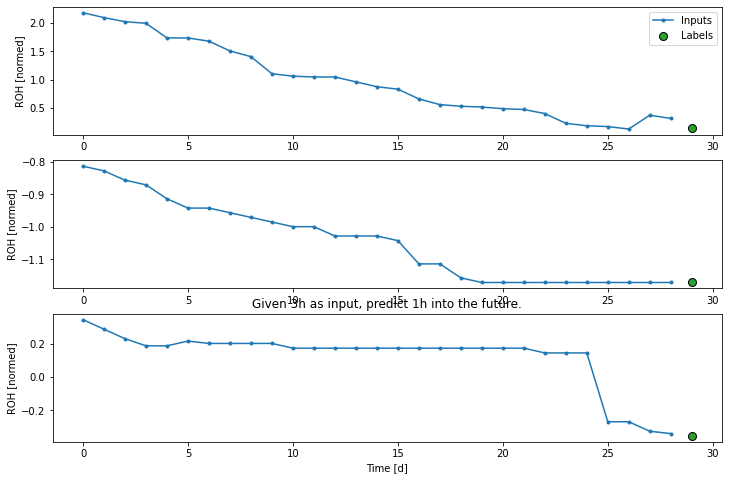

In [59]:
conv_window.plot()
plt.title("Given 3h as input, predict 1h into the future.")

In [60]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [61]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (90, 29, 11)
Output shape: (90, 1, 1)


In [62]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

144/144 [==============================] - 1s 4ms/step - loss: 0.0737 - mean_absolute_error: 0.1273


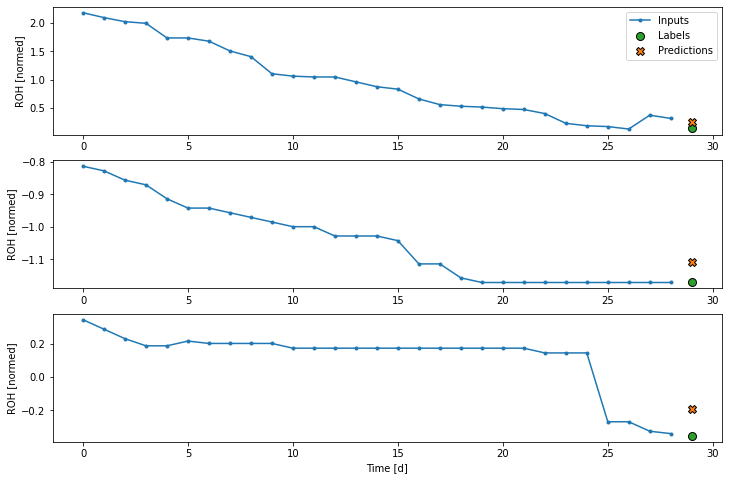

In [63]:
conv_window.plot(multi_step_dense)

In [57]:
print('Input shape:', wide_window.example[0].shape)
try:
  print('Output shape:', multi_step_dense(wide_window.example[0]).shape)
except Exception as e:
  print(f'\n{type(e).__name__}:{e}')

Input shape: (90, 24, 11)

InvalidArgumentError:Matrix size-incompatible: In[0]: [90,264], In[1]: [66,32] [Op:MatMul]


## Convolution Neural Network

In [64]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [65]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (90, 29, 11)
Output shape: (90, 1, 1)


In [66]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

144/144 [==============================] - 1s 4ms/step - loss: 0.0794 - mean_absolute_error: 0.1084


In [67]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (90, 24, 11)
Labels shape: (90, 24, 1)


InvalidArgumentError: Computed output size would be negative: -4 [input_size: 24, effective_filter_size: 29, stride: 1] [Op:Conv2D]

In [69]:
LABEL_WIDTH = 29
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['ROH'])

wide_conv_window

Total window size: 58
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56]
Label indices: [29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52
 53 54 55 56 57]
Label column name(s): ['ROH']

In [70]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (90, 57, 11)
Labels shape: (90, 29, 1)
Output shape: (90, 29, 1)


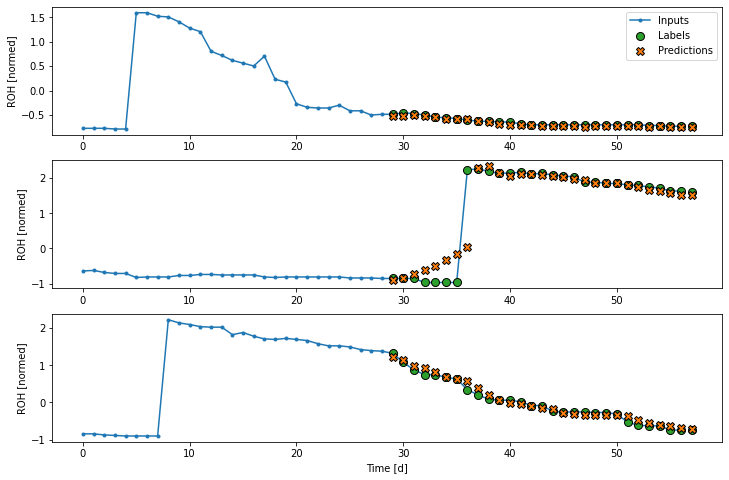

In [71]:
wide_conv_window.plot(conv_model)

## Recurrent Neural Network

In [72]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [73]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (90, 24, 11)
Output shape: (90, 24, 1)


In [74]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

144/144 [==============================] - 1s 6ms/step - loss: 0.0598 - mean_absolute_error: 0.0693


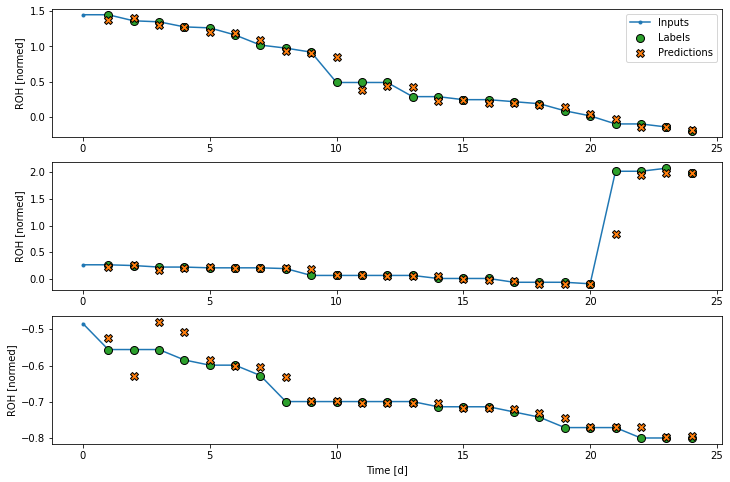

In [75]:
wide_window.plot(lstm_model)

## Performance

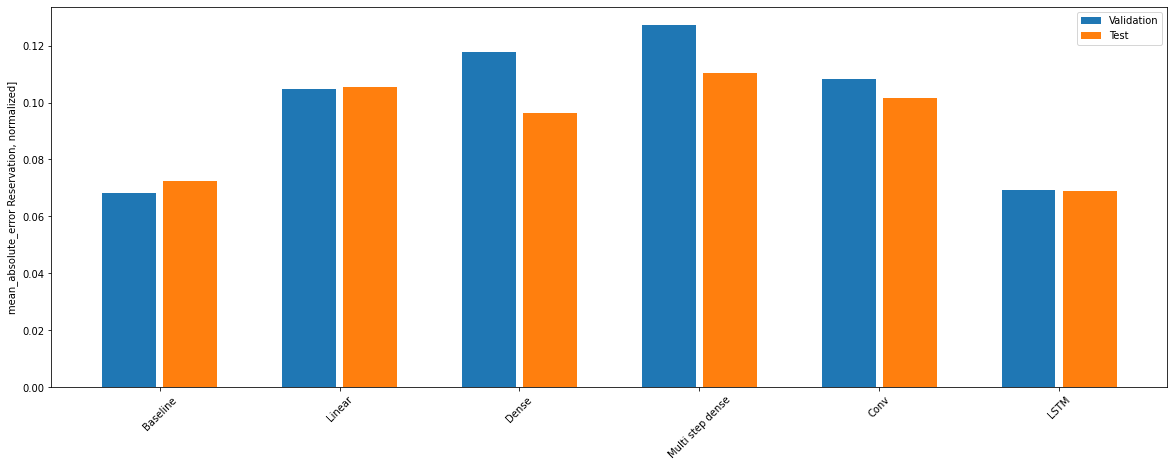

In [76]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error Reservation, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [77]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 0.0725
Linear      : 0.1055
Dense       : 0.0963
Multi step dense: 0.1105
Conv        : 0.1015
LSTM        : 0.0690


# Multi-Output Models

In [38]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=30, label_width=30, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (90, 30, 11)
Labels shape (batch, time, features): (90, 30, 11)


## Baseline

In [39]:
baseline = Baseline()
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

In [40]:
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

133/133 [==============================] - 0s 3ms/step - loss: 0.0265 - mean_absolute_error: 0.0191


## Dense

In [41]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

In [42]:
history = compile_and_fit(dense, single_step_window)

IPython.display.clear_output()
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

NameError: name 'compile_and_fit' is not defined

## RNN

In [90]:
wide_window = WindowGenerator(
    input_width=30, label_width=30, shift=1)

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate( wide_window.val)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=0)

144/144 [==============================] - 1s 7ms/step - loss: 0.0090 - mean_absolute_error: 0.0317


## Advance Resedule

In [91]:
class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # The prediction for each timestep is the input
    # from the previous time step plus the delta
    # calculated by the model.
    return inputs + delta

In [92]:
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small
        # So initialize the output layer with zeros
        kernel_initializer=tf.initializers.zeros)
]))

history = compile_and_fit(residual_lstm, wide_window)

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)

144/144 [==============================] - 1s 7ms/step - loss: 0.0063 - mean_absolute_error: 0.0159


## Performance

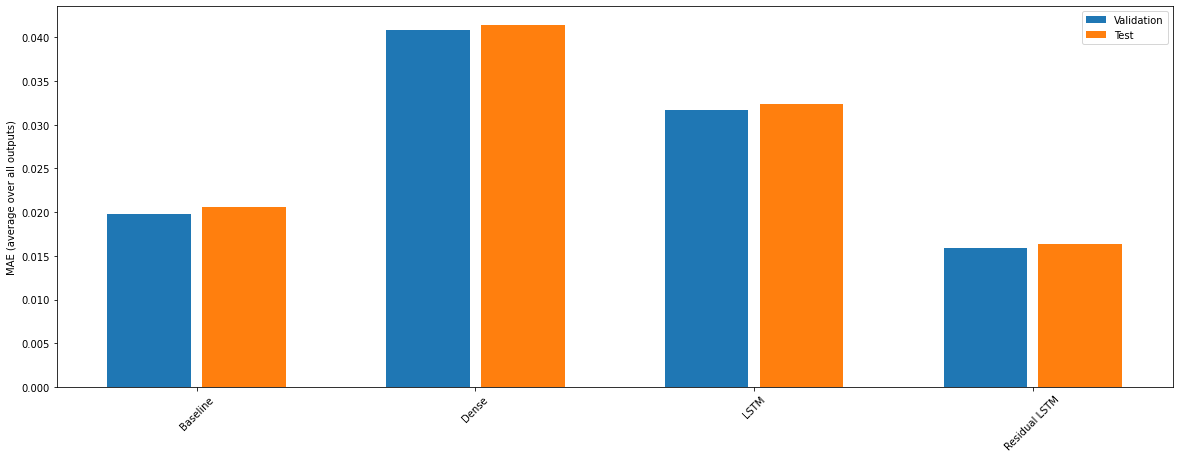

In [93]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

In [94]:
for name, value in performance.items():
  print(f'{name:15s}: {value[1]:0.4f}')

Baseline       : 0.0206
Dense          : 0.0415
LSTM           : 0.0324
Residual LSTM  : 0.0163


# Multistep Models

Total window size: 60
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53
 54 55 56 57 58 59]
Label column name(s): None

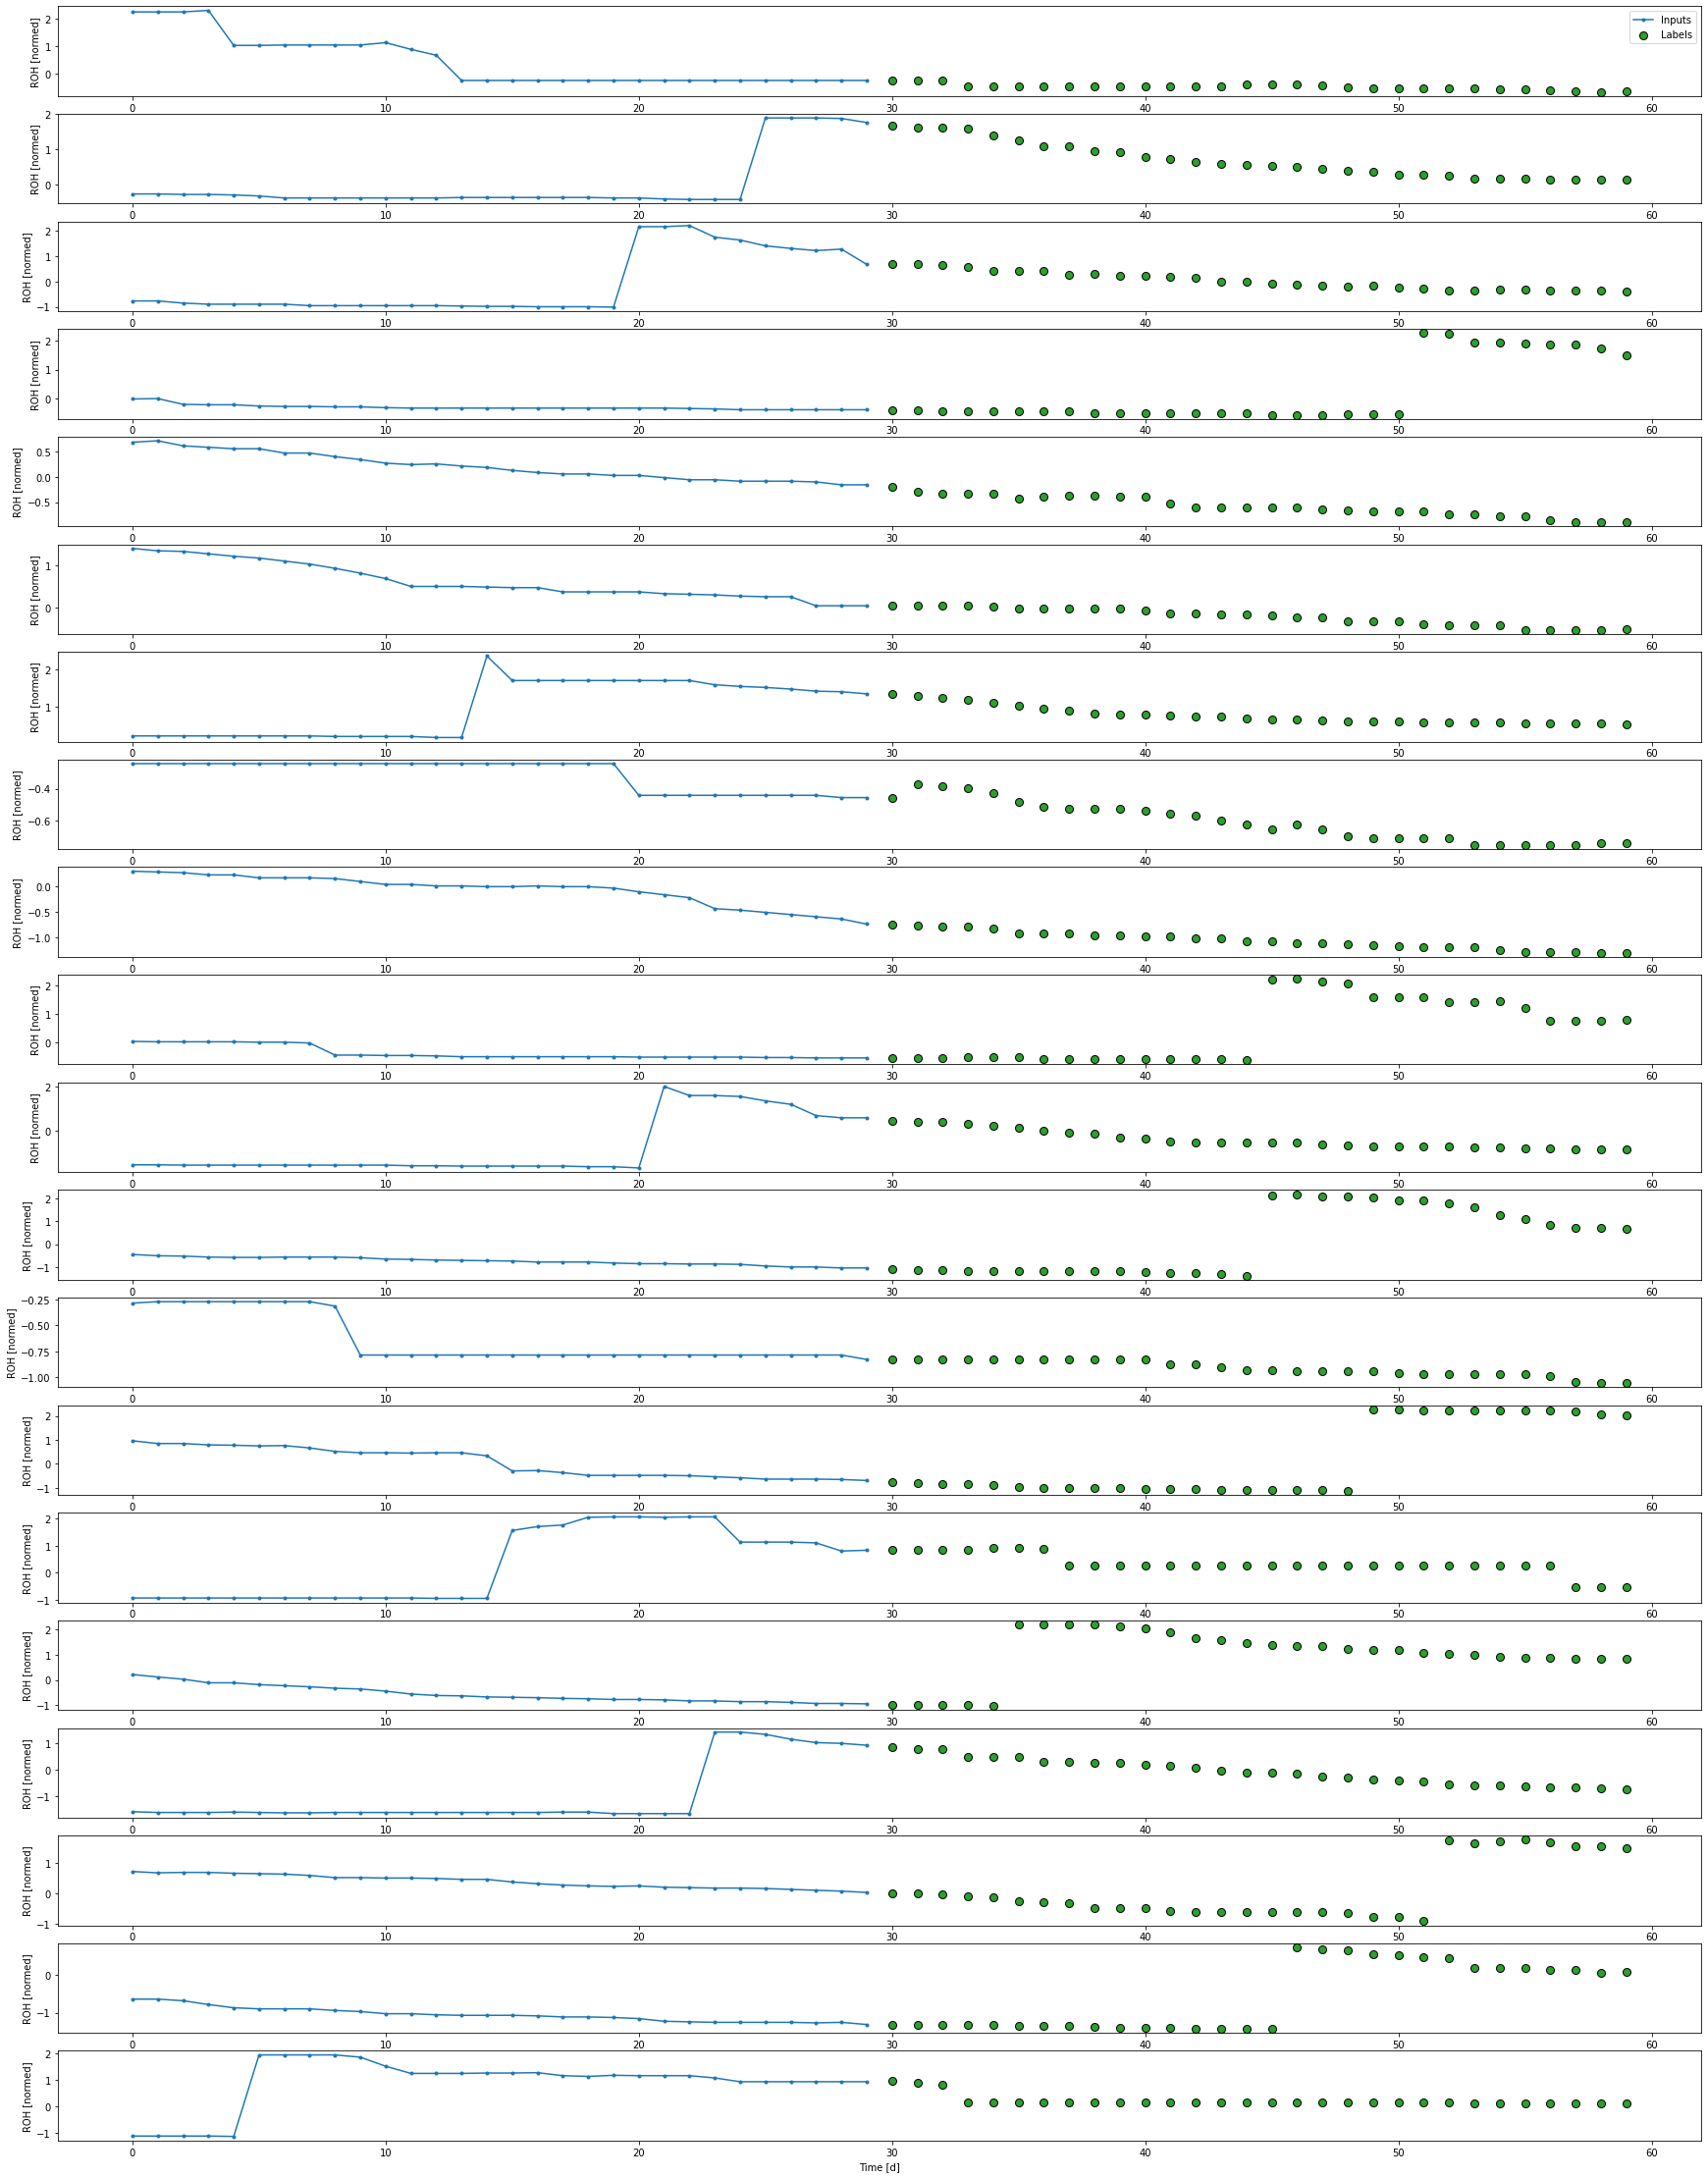

In [29]:
OUT_STEPS = 30
multi_window = WindowGenerator(input_width=30,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

133/133 [==============================] - 0s 3ms/step - loss: 0.3370 - mean_absolute_error: 0.2111


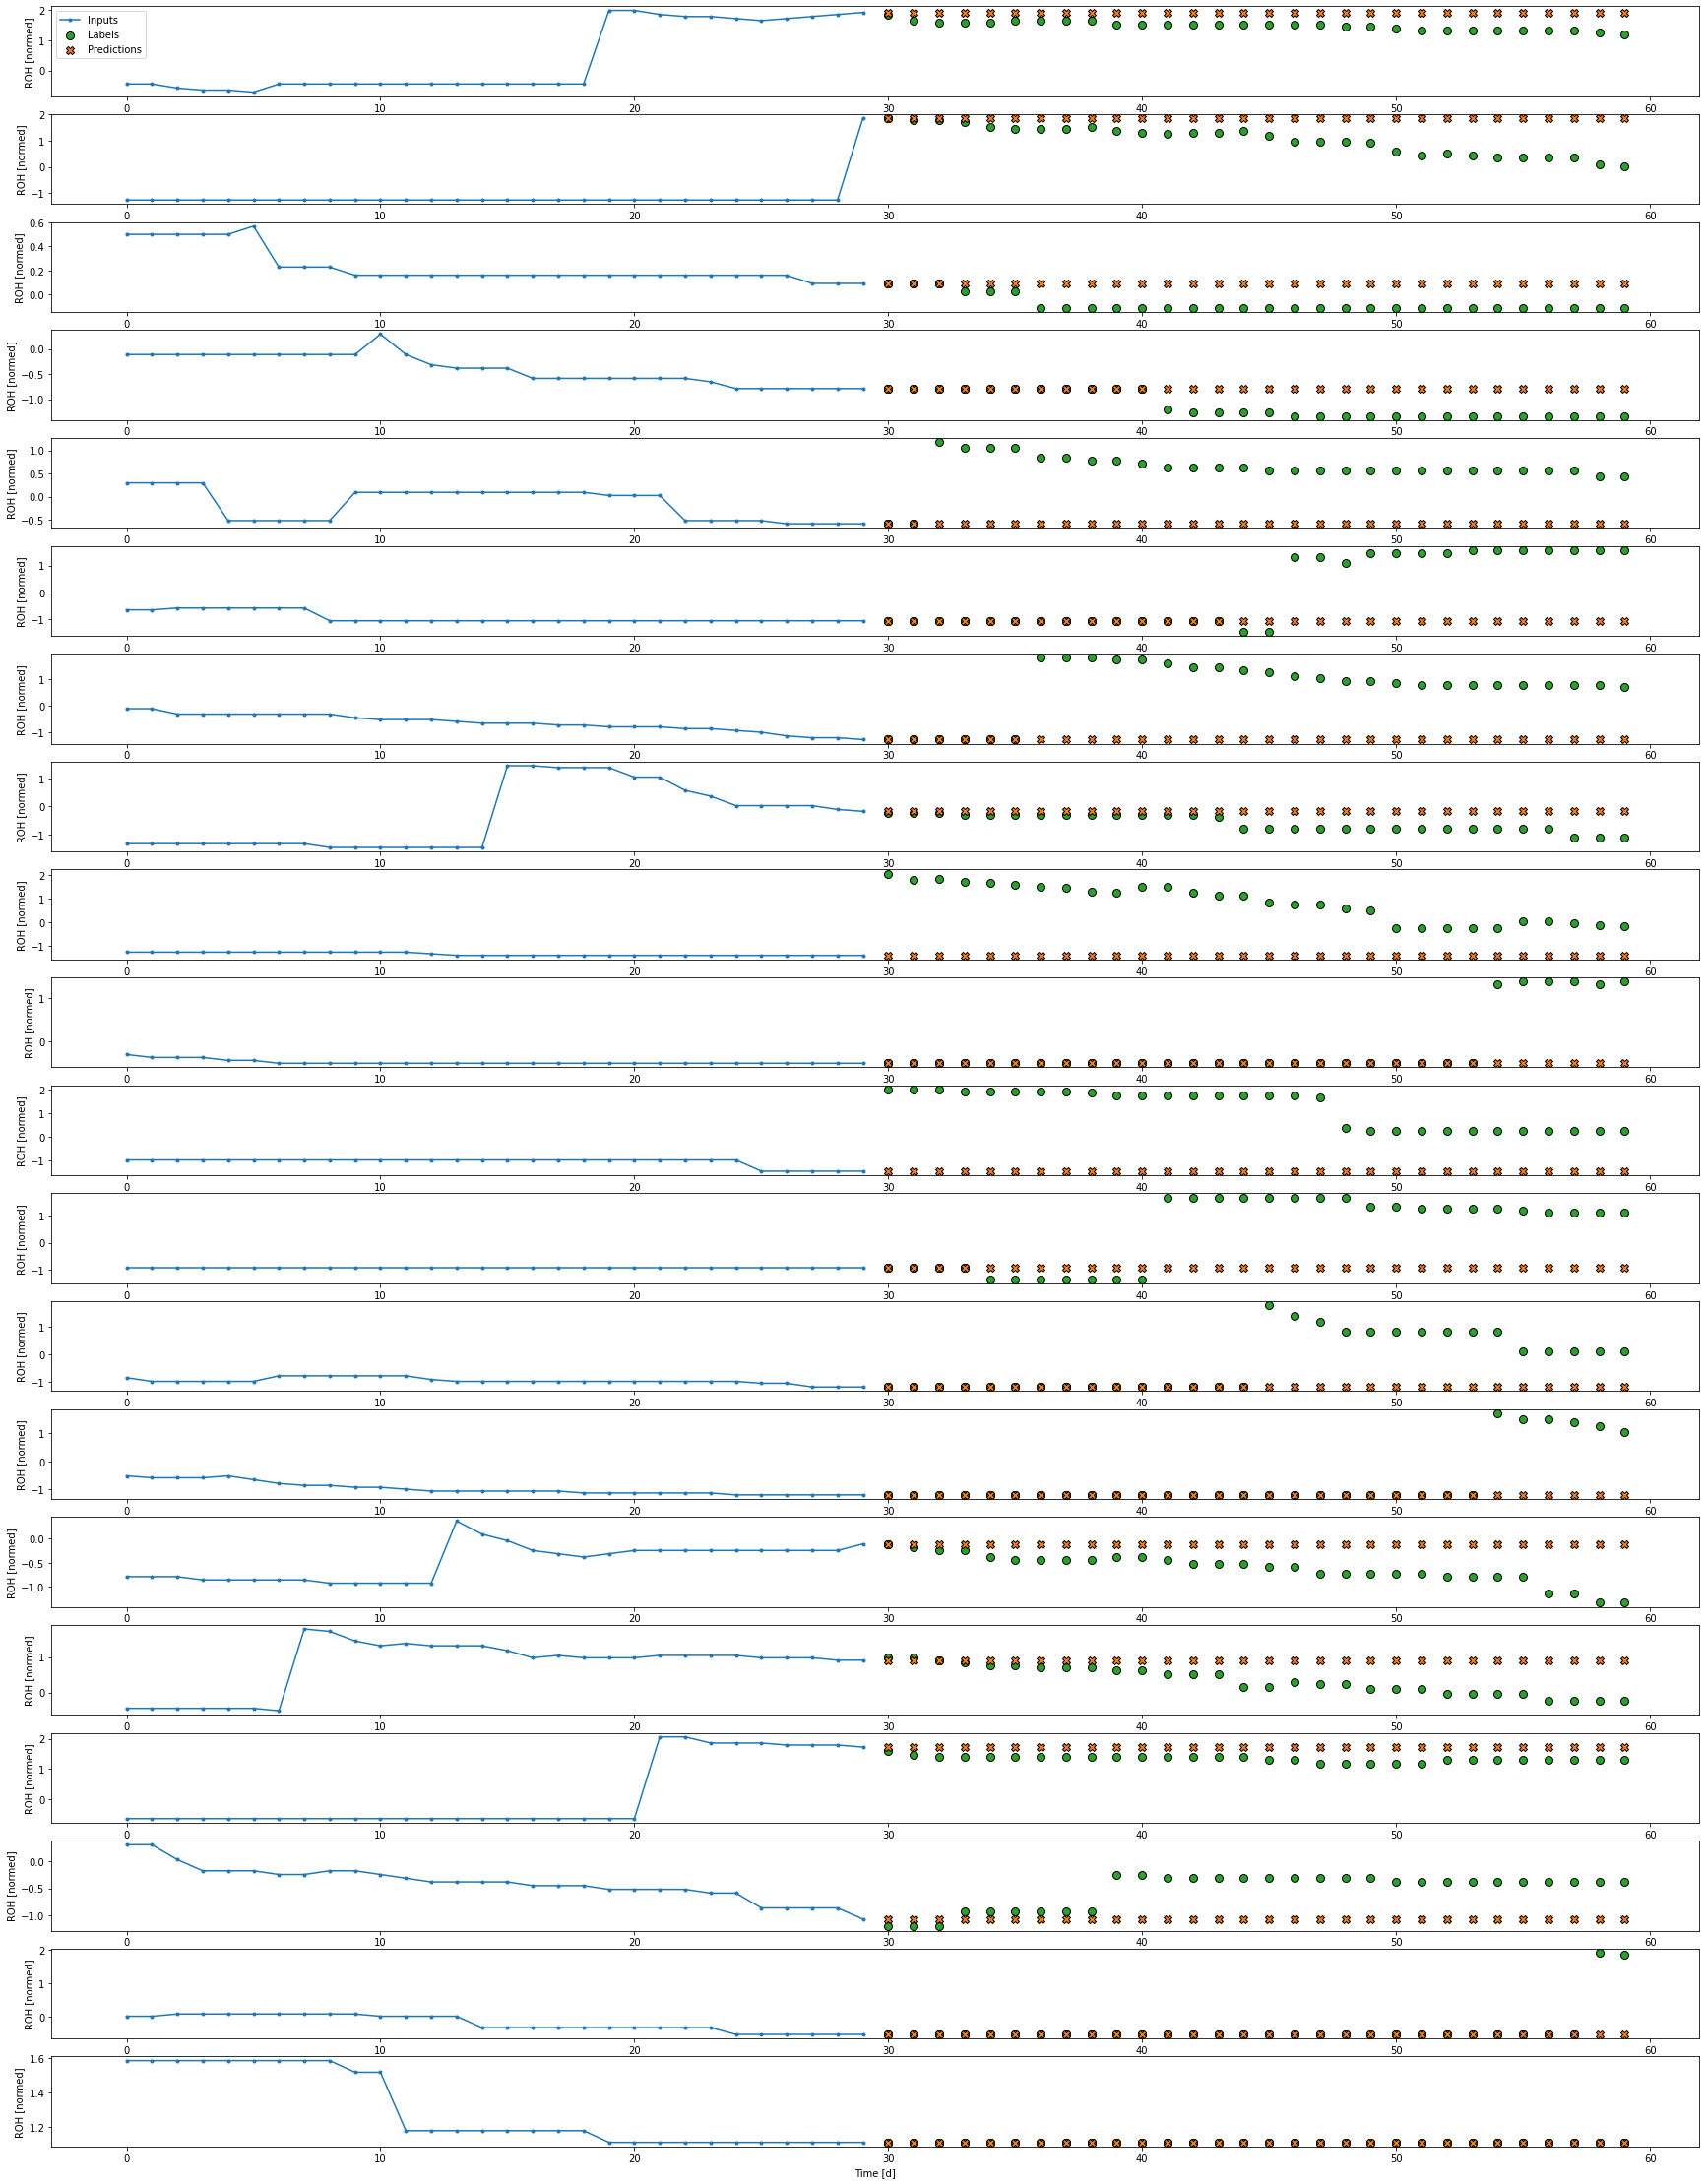

In [46]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

133/133 [==============================] - 0s 3ms/step - loss: 0.5882 - mean_absolute_error: 0.3632


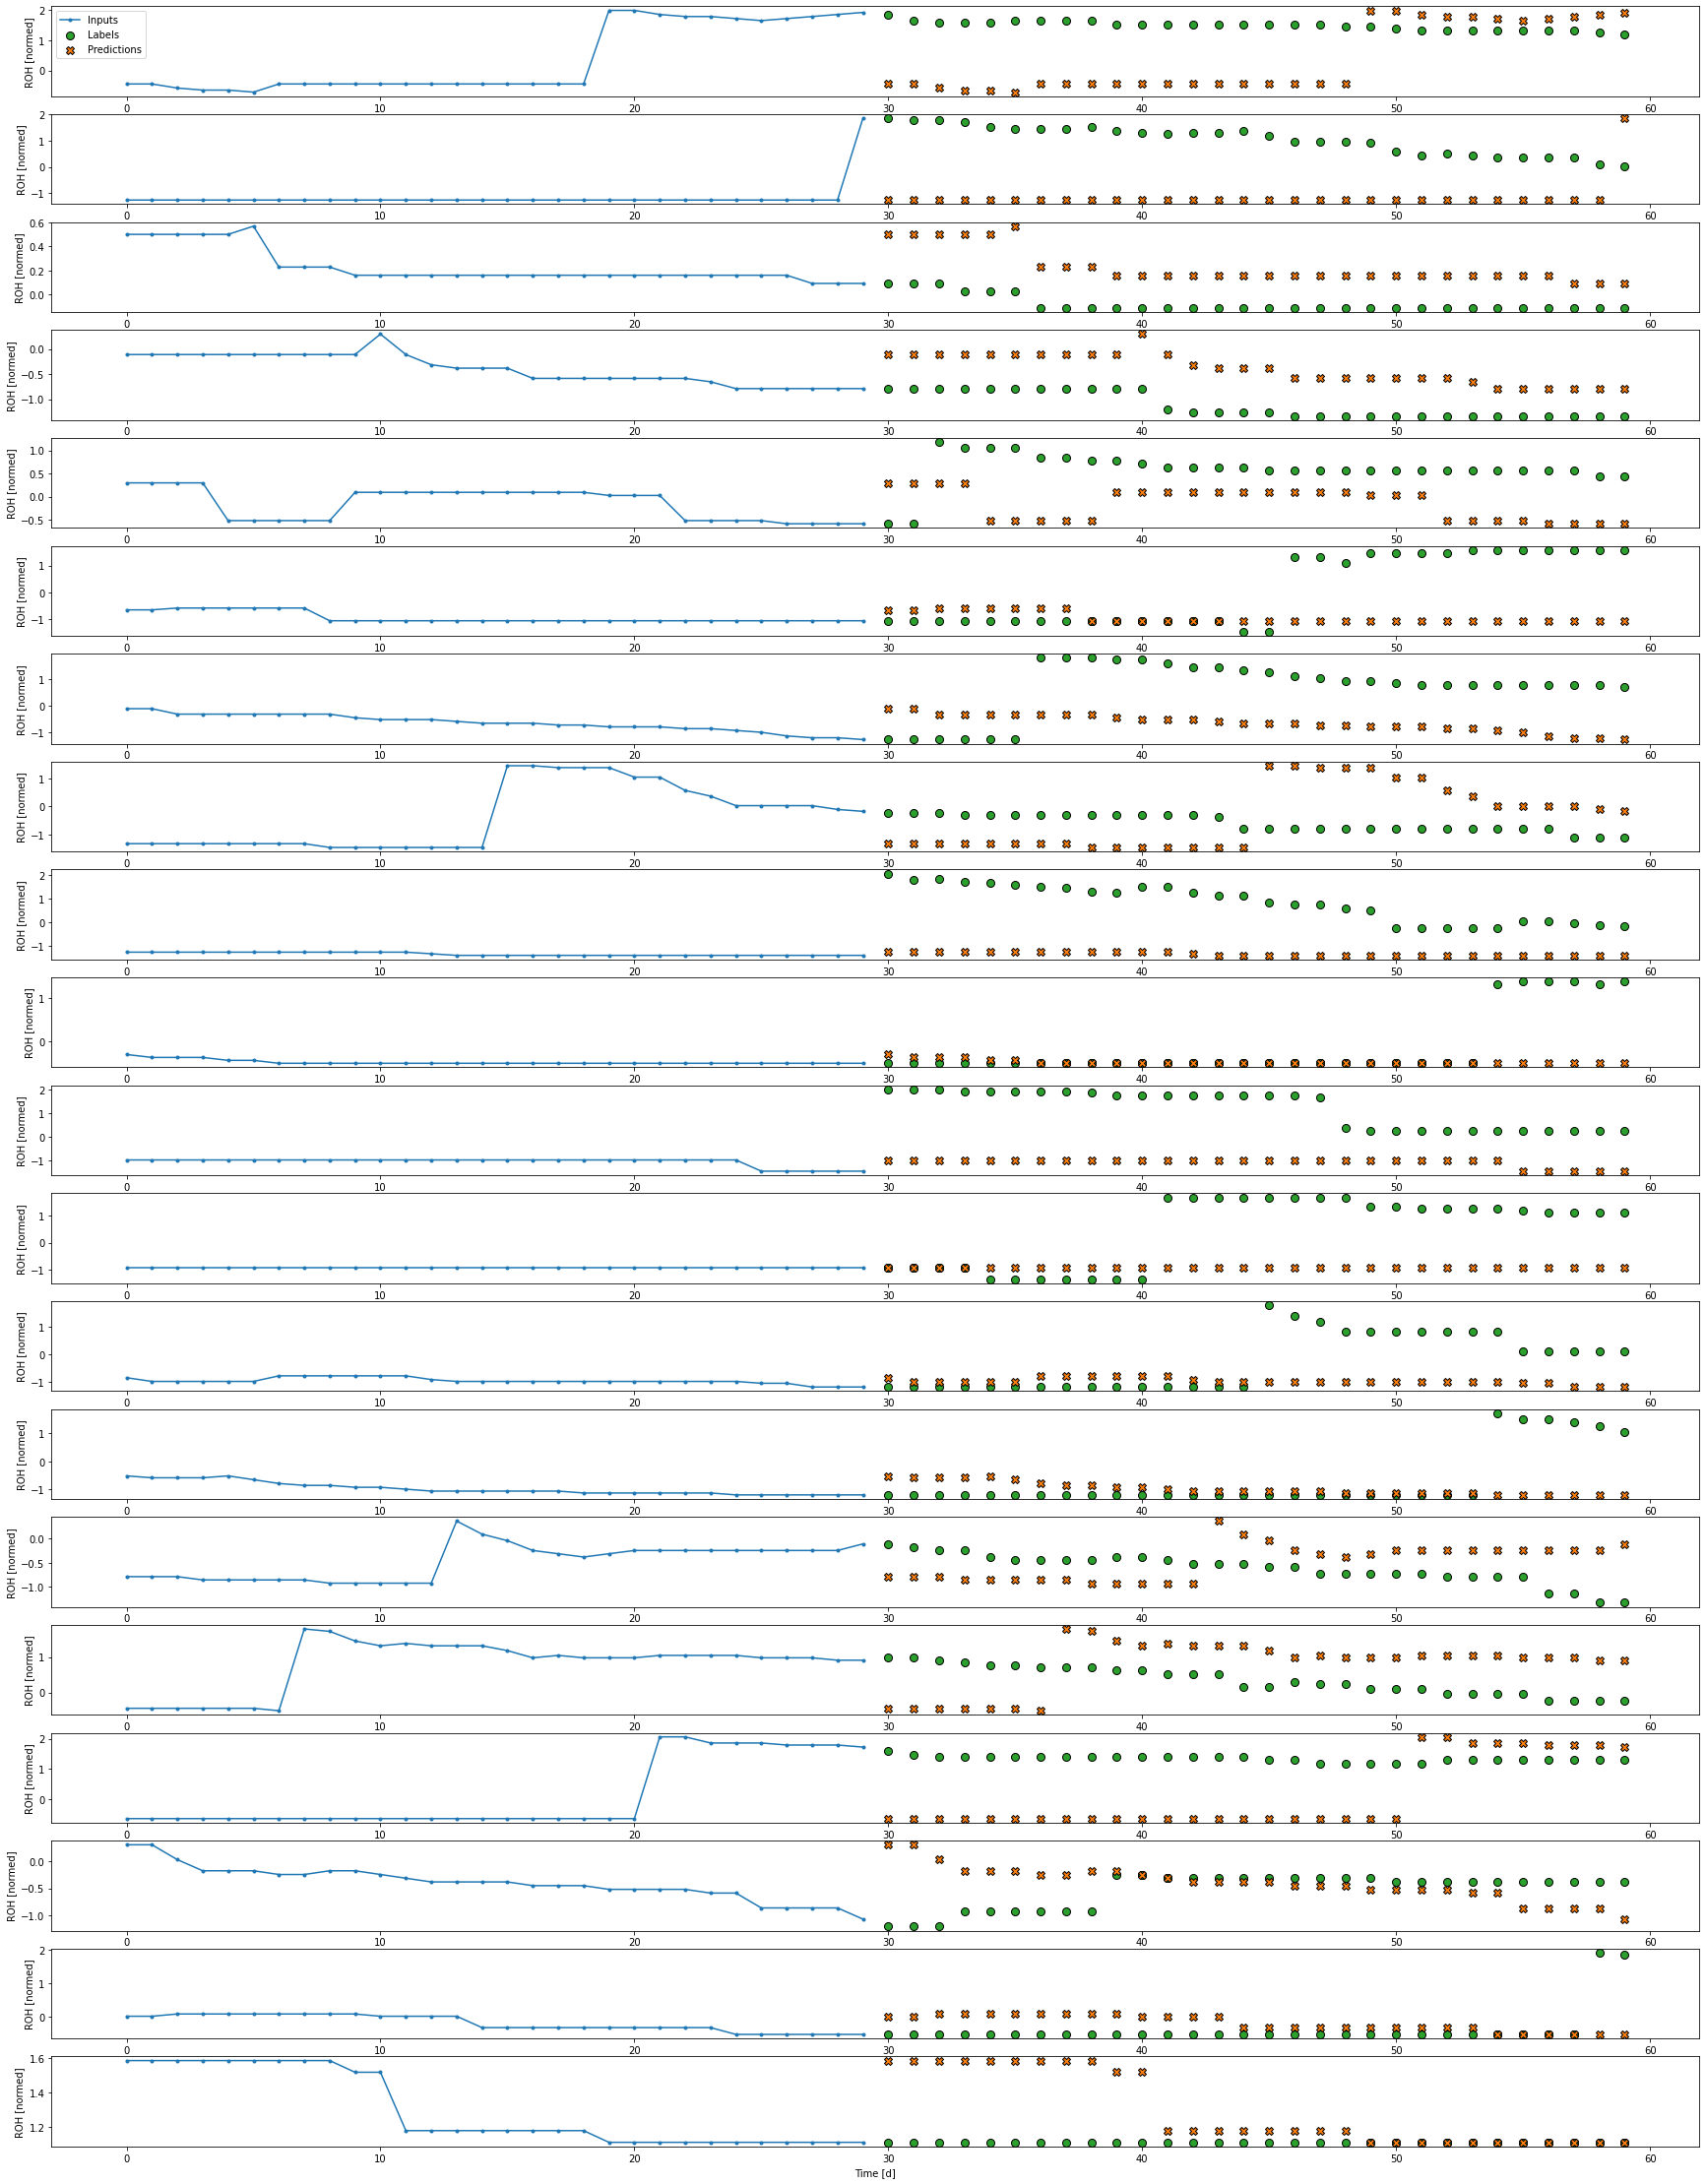

In [47]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

## Linear

133/133 [==============================] - 0s 4ms/step - loss: 0.2155 - mean_absolute_error: 0.2145


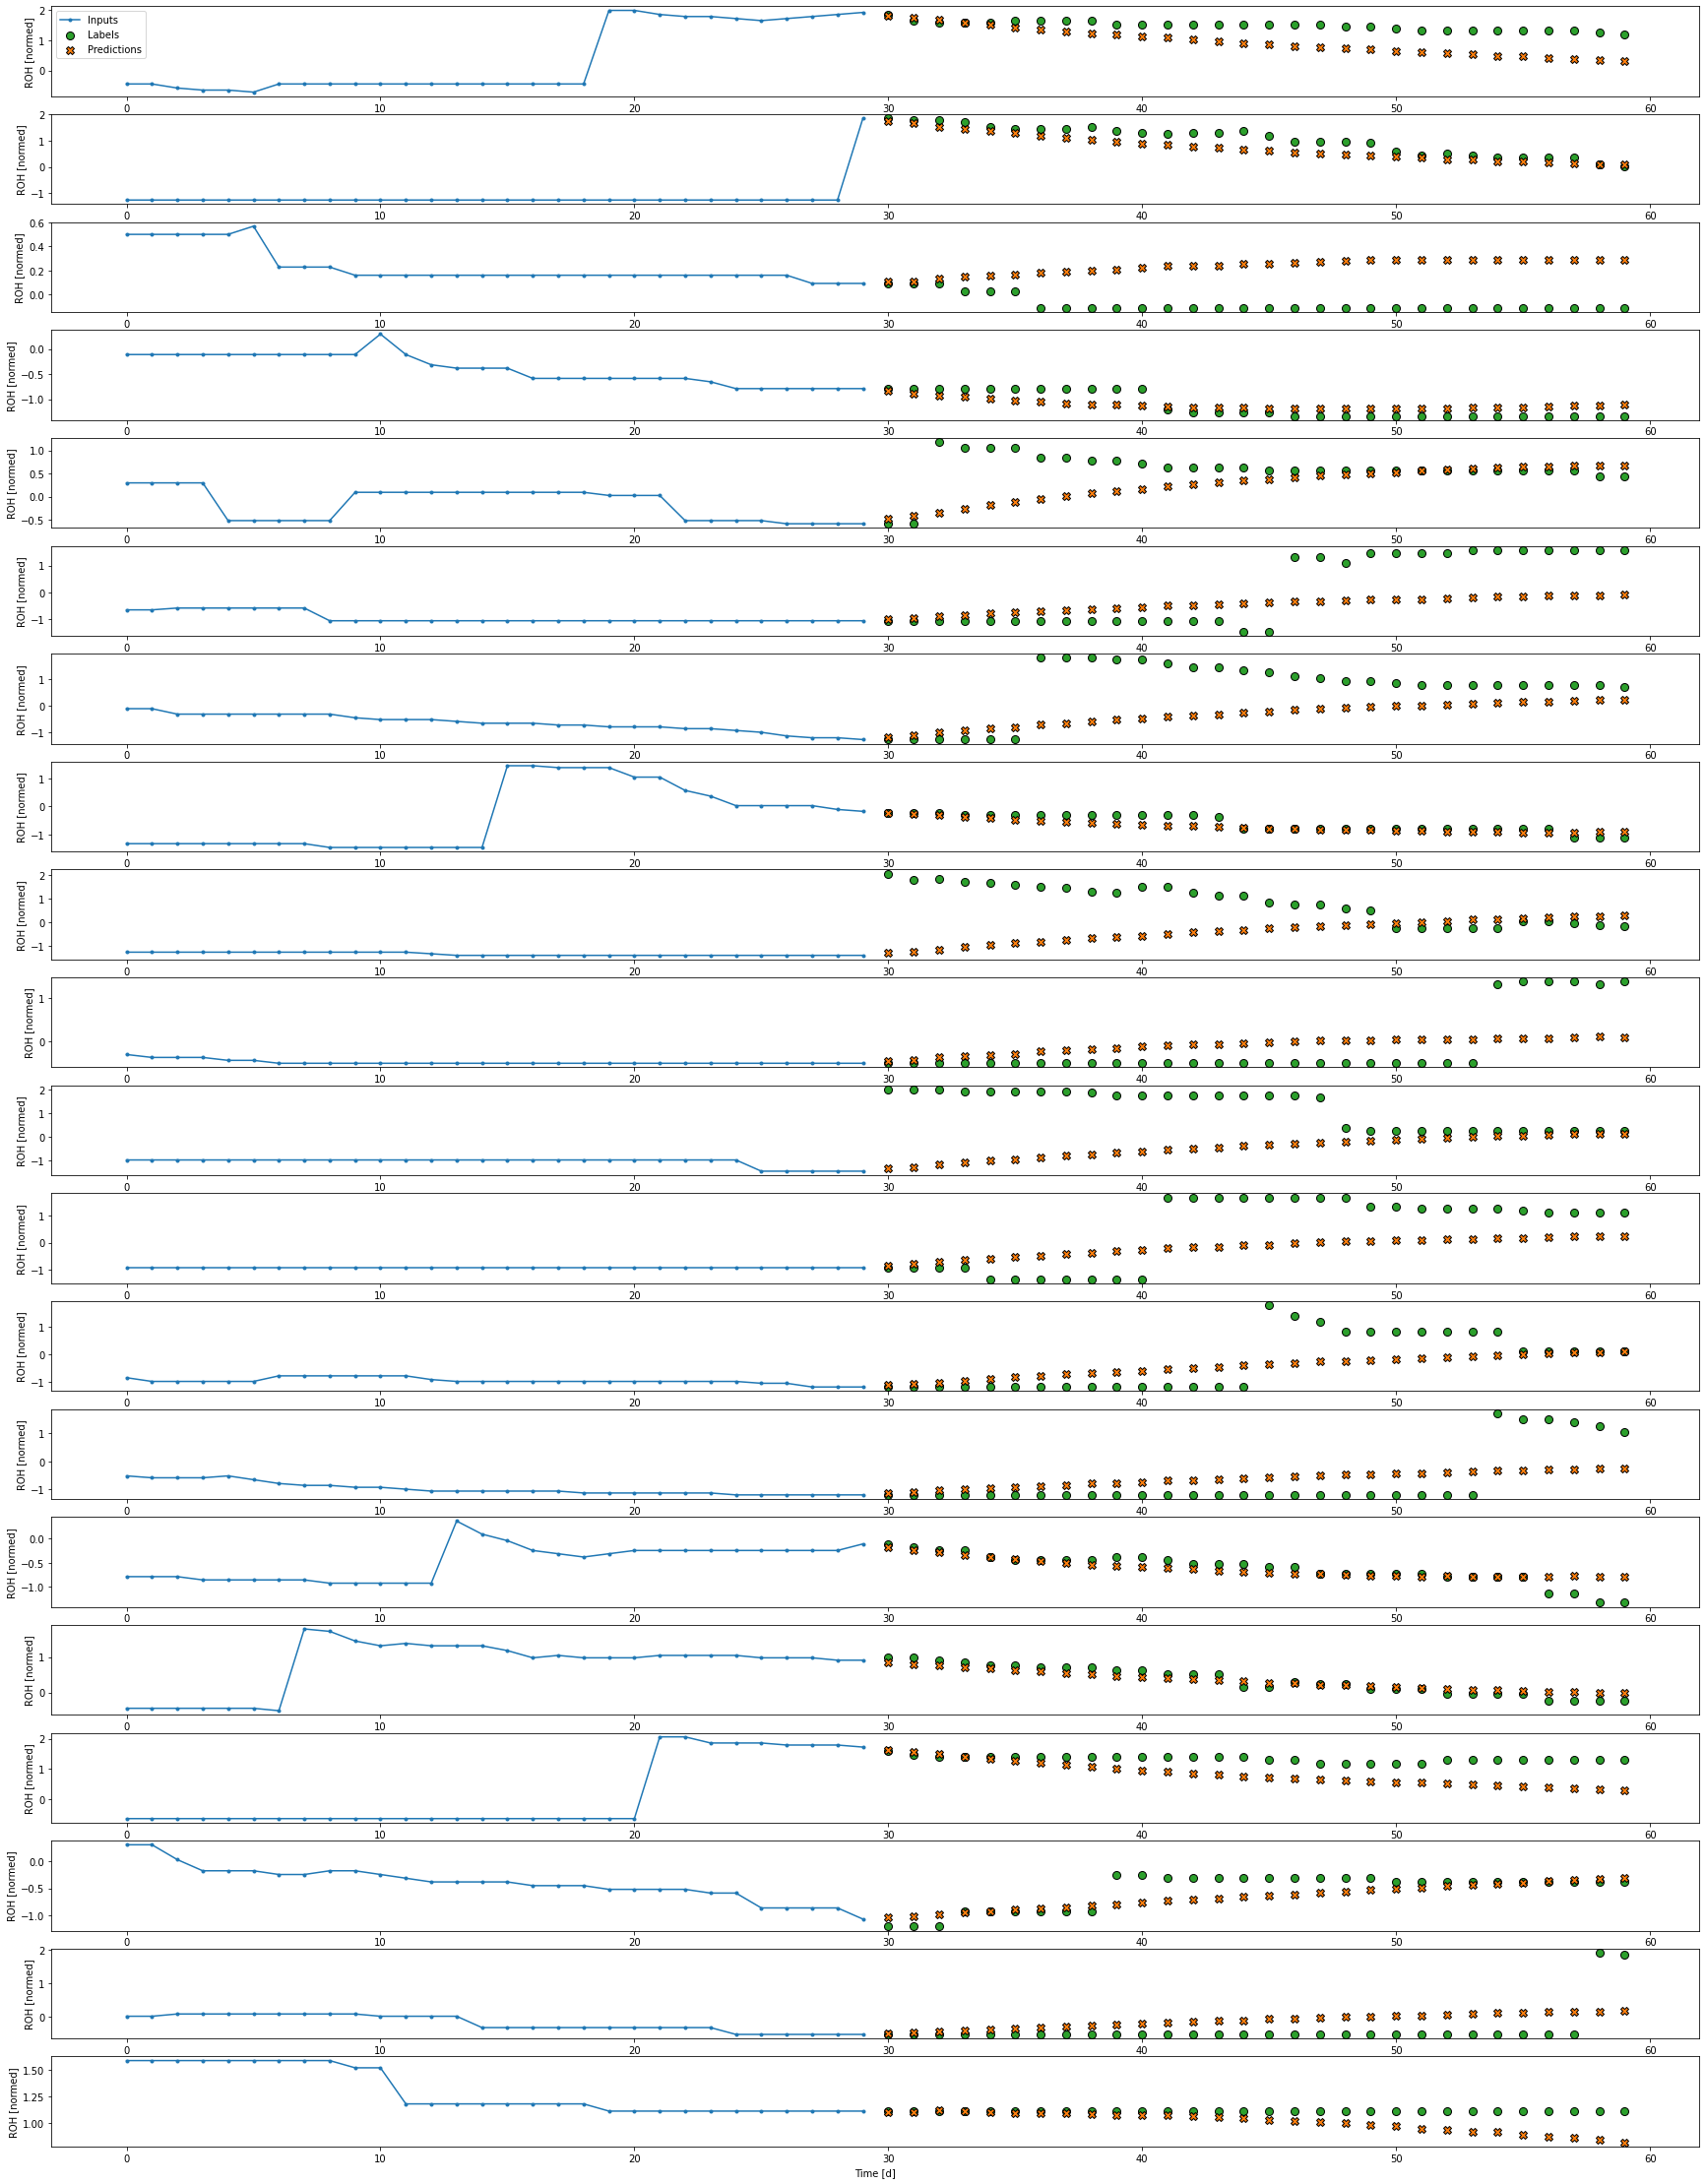

In [48]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

## Dense

144/144 [==============================] - 1s 4ms/step - loss: 0.0754 - mean_absolute_error: 0.1161


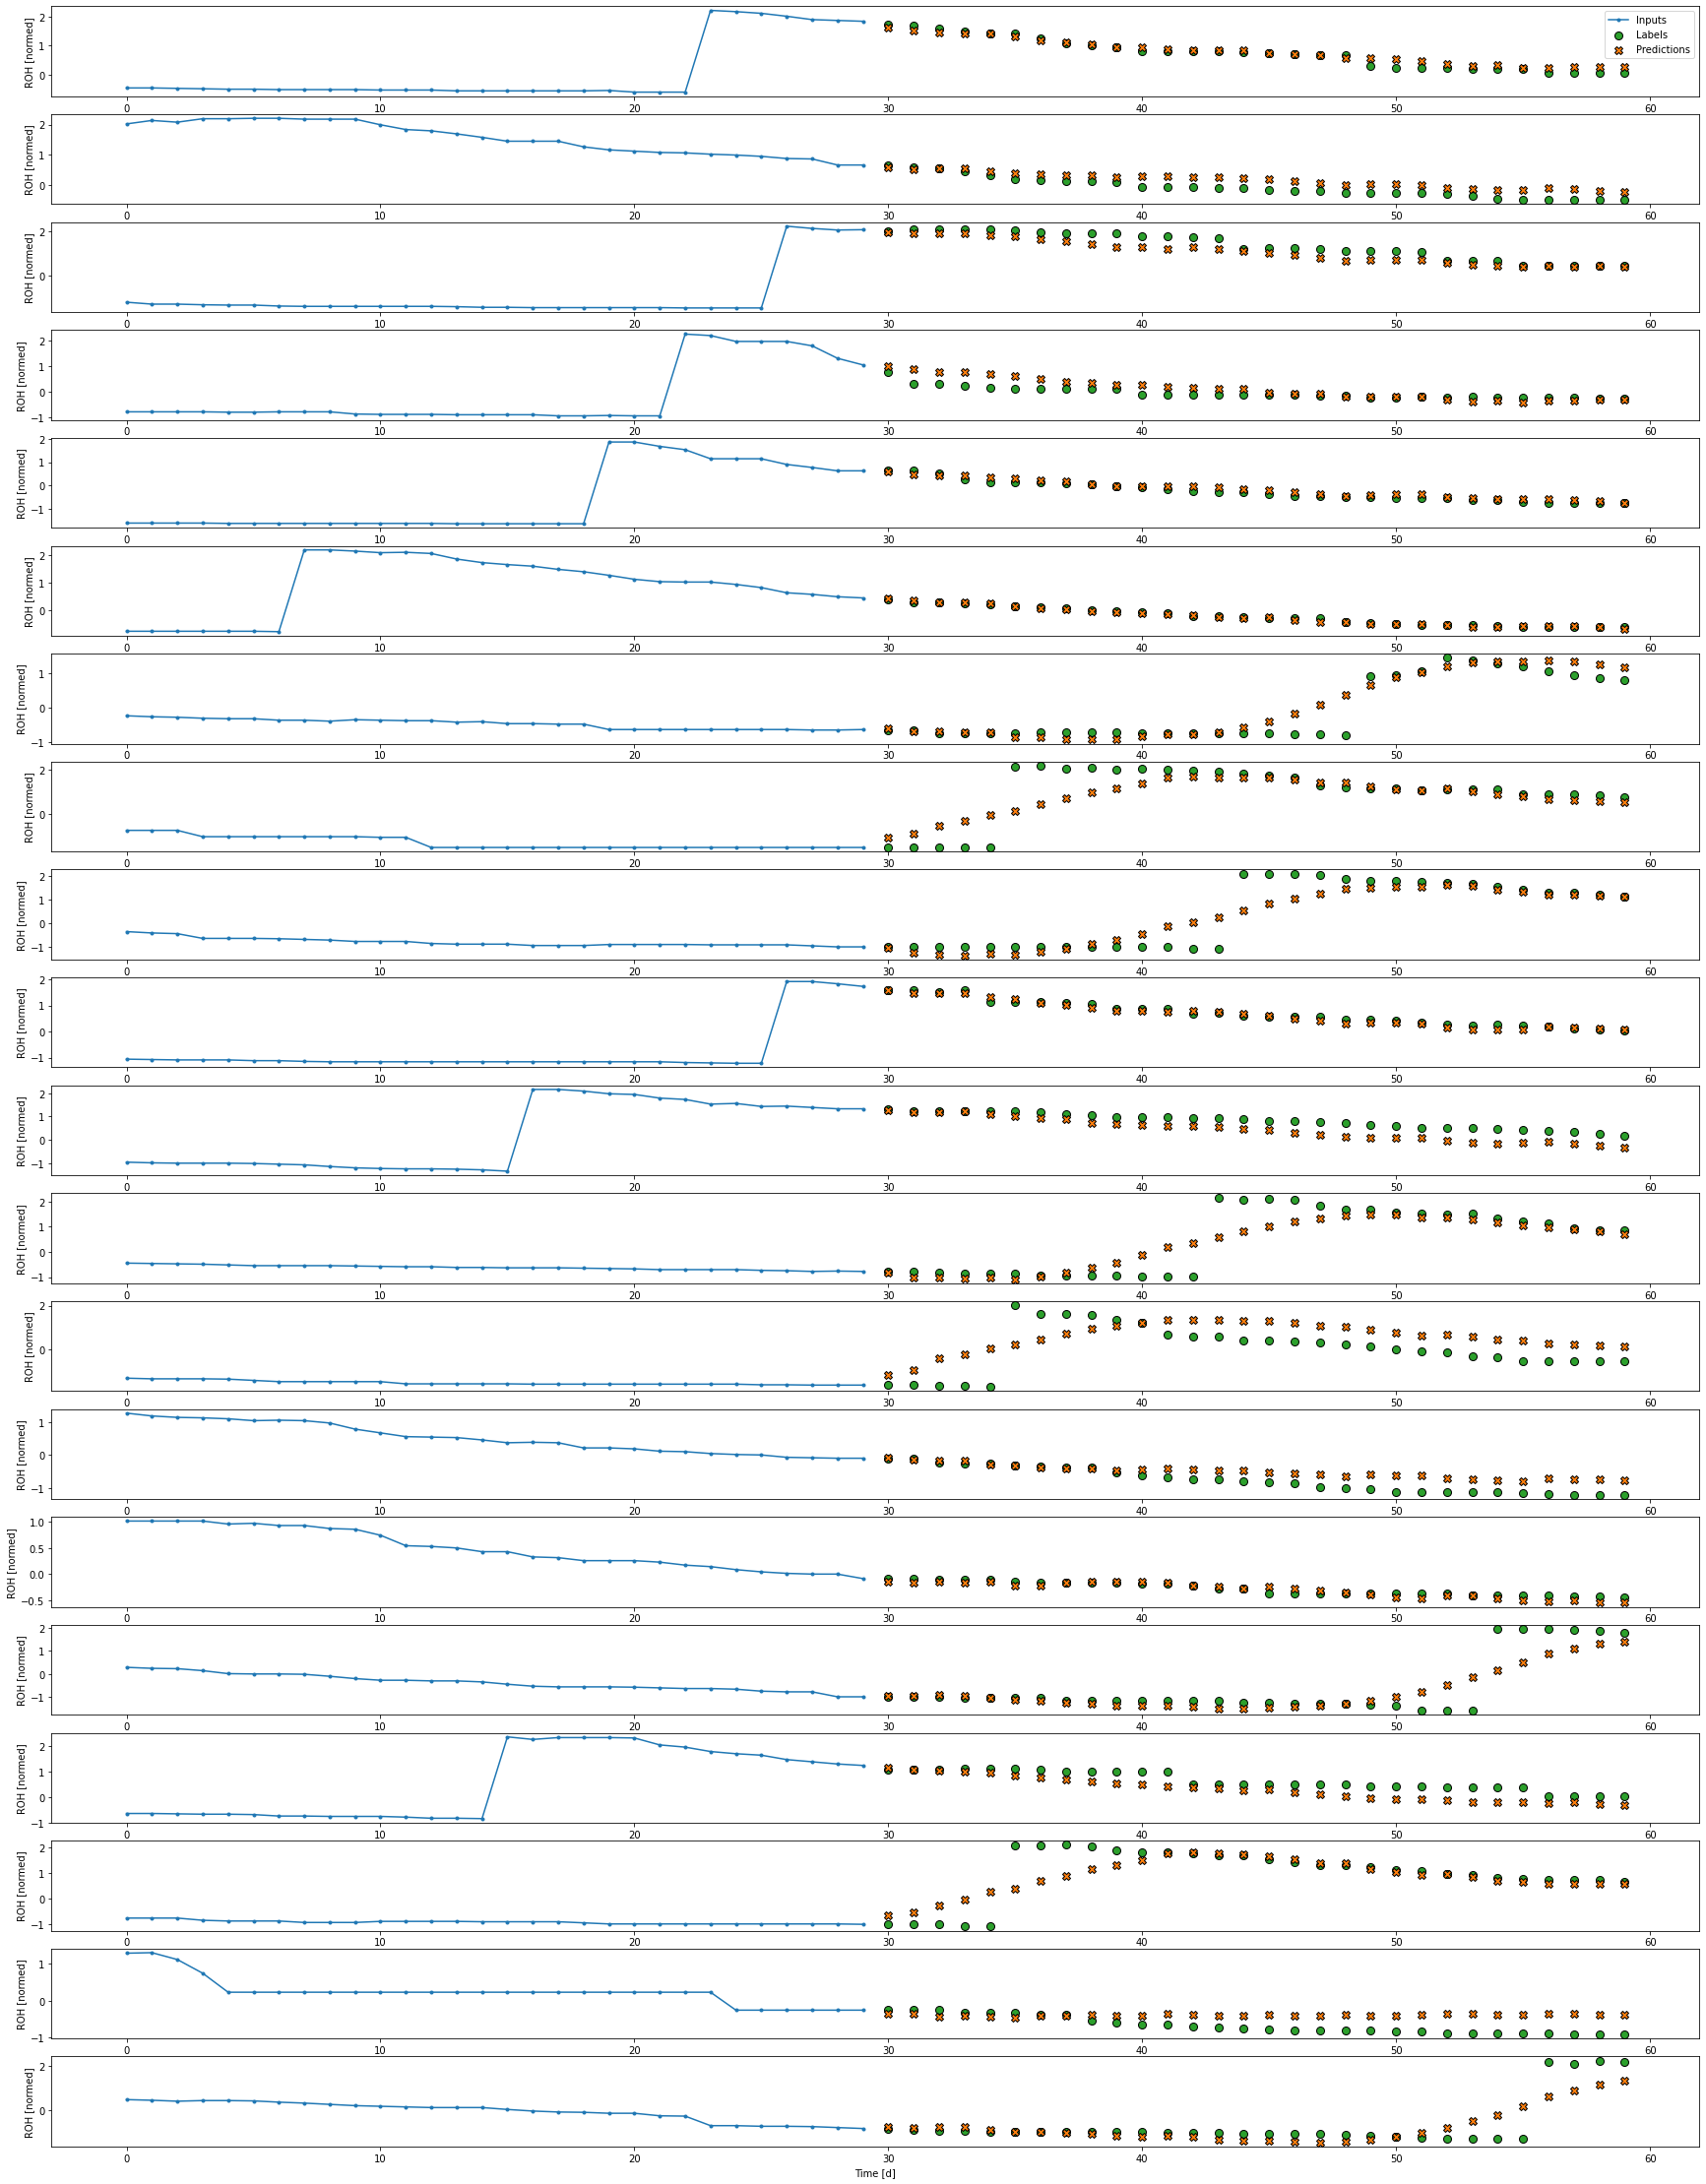

In [57]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

## CNN

144/144 [==============================] - 1s 4ms/step - loss: 0.0757 - mean_absolute_error: 0.1237


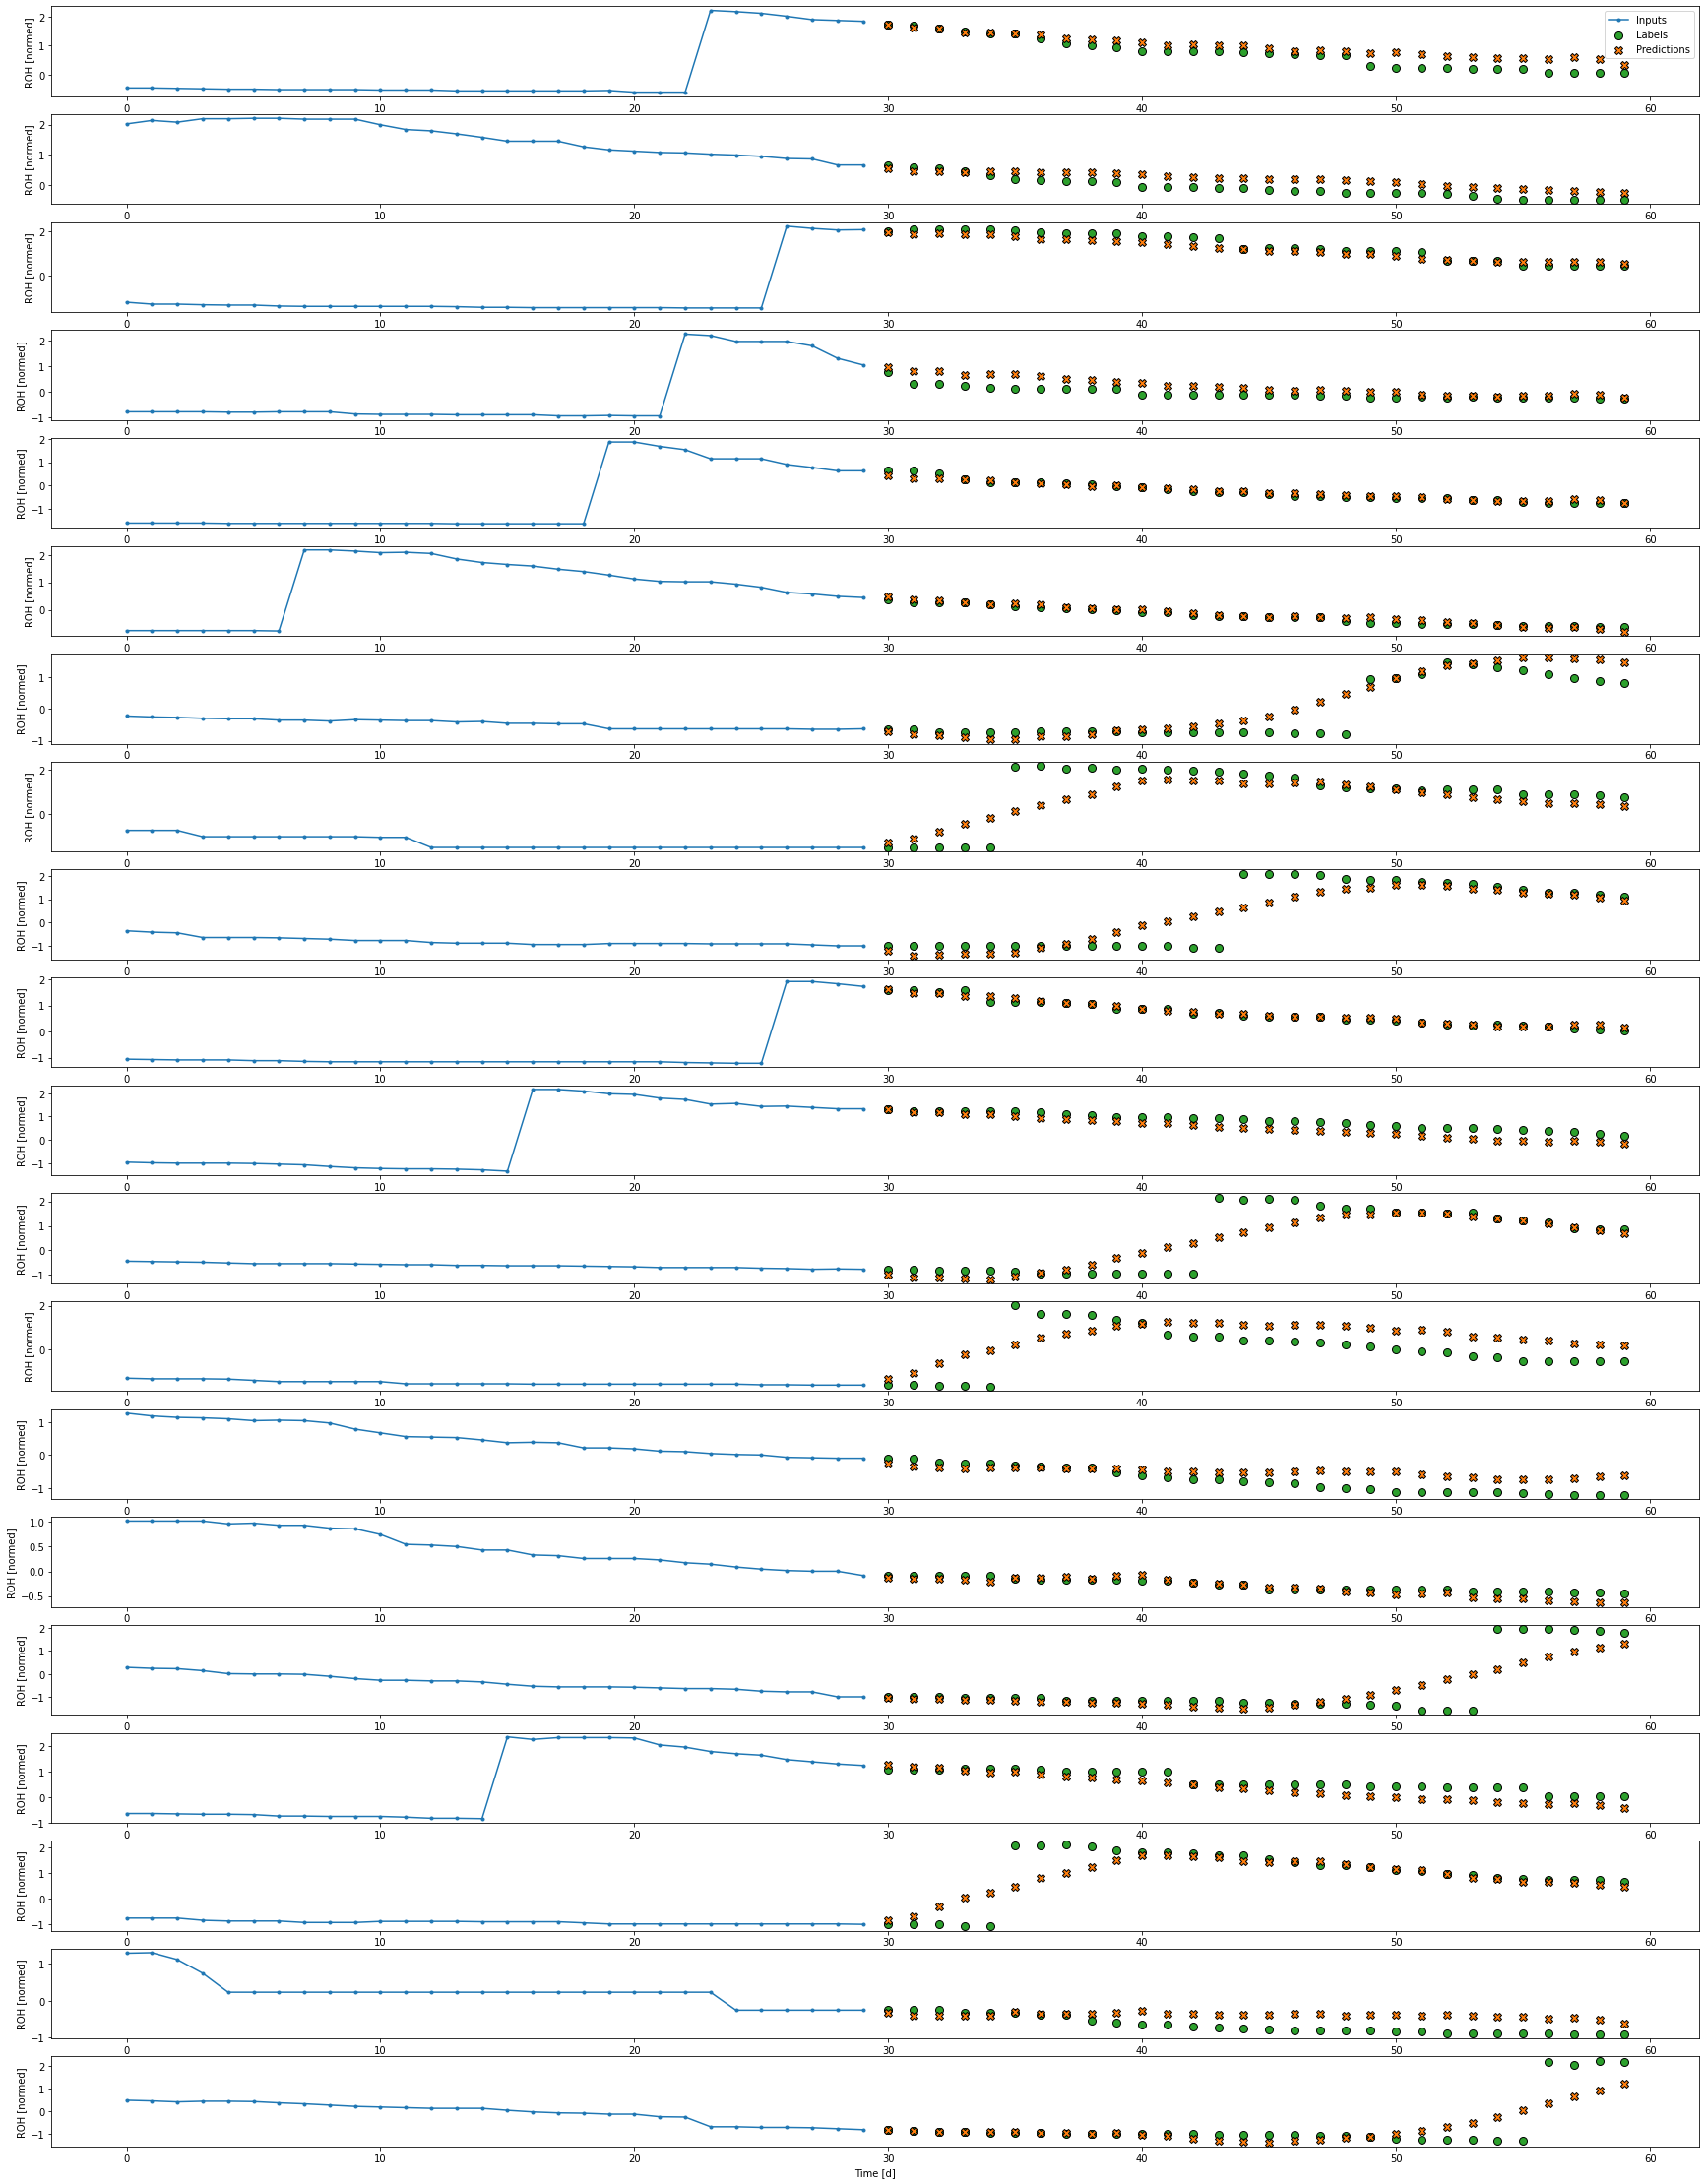

In [58]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

## RNN

In [32]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

144/144 [==============================] - 1s 9ms/step - loss: 0.0663 - mean_absolute_error: 0.1109


NameError: name 'multi_val_performance' is not defined

## Auto Regressive 

In [50]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

In [51]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

In [52]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

In [53]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([90, 11])

In [54]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the lstm state
  prediction, state = self.warmup(inputs)

  # Insert the first prediction
  predictions.append(prediction)

  # Run the rest of the prediction steps
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

In [55]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (90, 30, 11)


133/133 [==============================] - 1s 10ms/step - loss: 0.1147 - mean_absolute_error: 0.1610


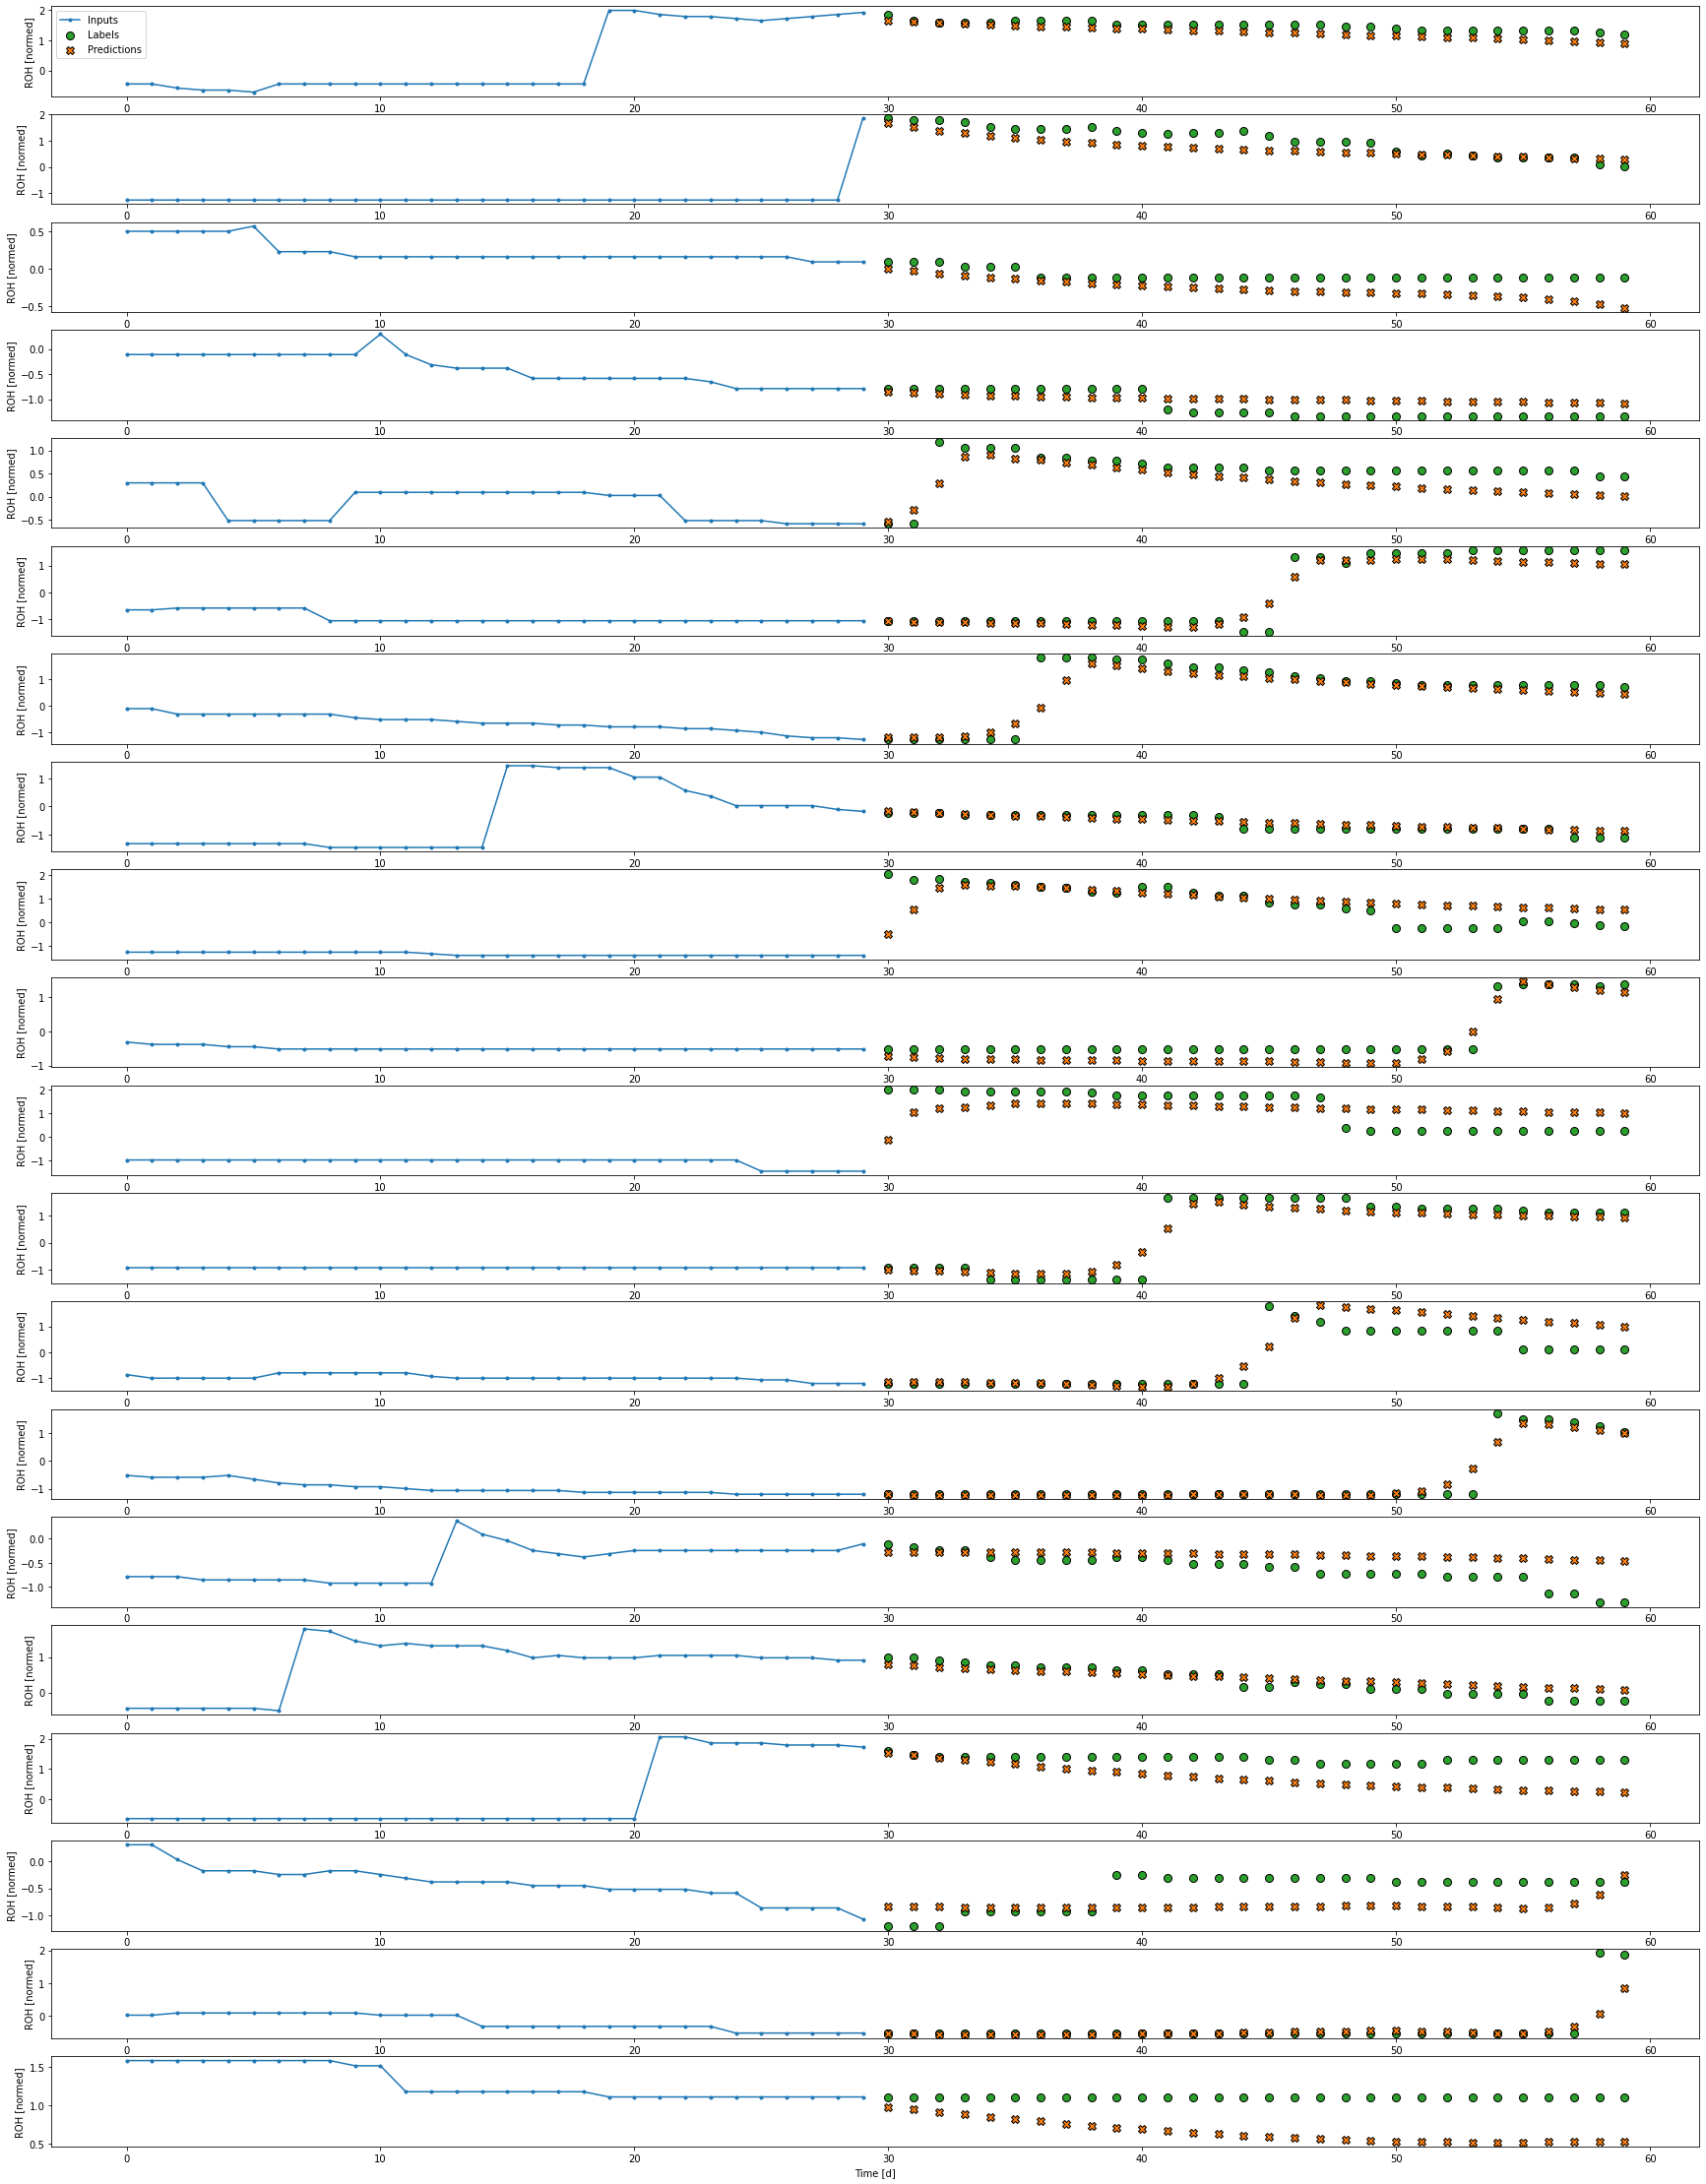

In [56]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

## Performance 

In [57]:
x = np.arange(len(multi_performance))
width = 0.3


metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

NameError: name 'lstm_model' is not defined

In [59]:
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

Last    : 0.2070
Repeat  : 0.3475
Linear  : 0.2070
LSTM    : 0.1288
AR LSTM : 0.1440
